# Transcription Factor Project
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Guiding Questions:**
*  What TF KOs are present in the dataset? 
*  When performing clustering with the dataset - can we associate a unique set of TFs with a cluster? Is there any functional significance to these clusters?
*  What gene targets are associated with these TFs?
*  Which TFs are involved in co-regulation, and which genes are co-regulated? Which TFs are regulated by other TFs?
*  How do TFs influence chromatin remodeling? Which sets of writers and erasers are regulated by these TFs?

***

# Import statements

In [1]:
import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
#import re
#import requests
import gc
#from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
#from sklearn.ensemble import IsolationForest
#from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
#import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import networkx as nx
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
#import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

Note: use terminal command " watch -n 0.1 free -h " to watch how much memory is being used

# QC pipeline

## Initial data read-in

We will read in the Perturb-seq single-cell dataset `.h5mu` file as a `MuData` object, `mdata`.

`mdata` contains two modalities which are `AnnData` objects: `rna` (cell-by-gene matrix) and `crispr` (cell-by-knockout matrix)
- `rna`: 5386783 cells x 38606 features  
    - Features = expression of each human gene measured in the dataset
    - `.obs` = cell barcodes, `.var` = features = genes
- `crispr`: 5386783 cells x 35989 features
    - Features = CRISPR sgRNAs (3 sgRNAs per gene target * 11739 gene targets, plus 478 non-targeting control sgRNAs)
    - `.obs` = cell barcodes, `.var` = features = knockouts

We will be working with the `rna` modality for the majority of the analysis. We will assign it to the variable `adata`.

In [ ]:
md_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Aggregate.h5mu"
mdata = mu.read_h5mu(md_filepath)
adata = mdata.mod["rna"]

In [ ]:
crispr = mdata.mod['crispr']

## Running pipeline

Note: functions written in `Pan_Genome_Analysis.ipynb` have been pasted into a file `pan_genome_analysis_functions.py` that is imported as `qc2`

### Step B: Assigning sgRNA to cells and de facto doublet detection

The lists of cells and genes provided by the Mali lab are the output of step D; however, steps E through F require metadata annotation, meaning that it would make the most sense to run the pipeline on the `KOLF_Pan_Genome_Aggregate.h5mu` file through step F. First, we will run step B: assigning sgRNA to cells based on the protospacer calls and removing cells without exactly one sgRNA assigned.

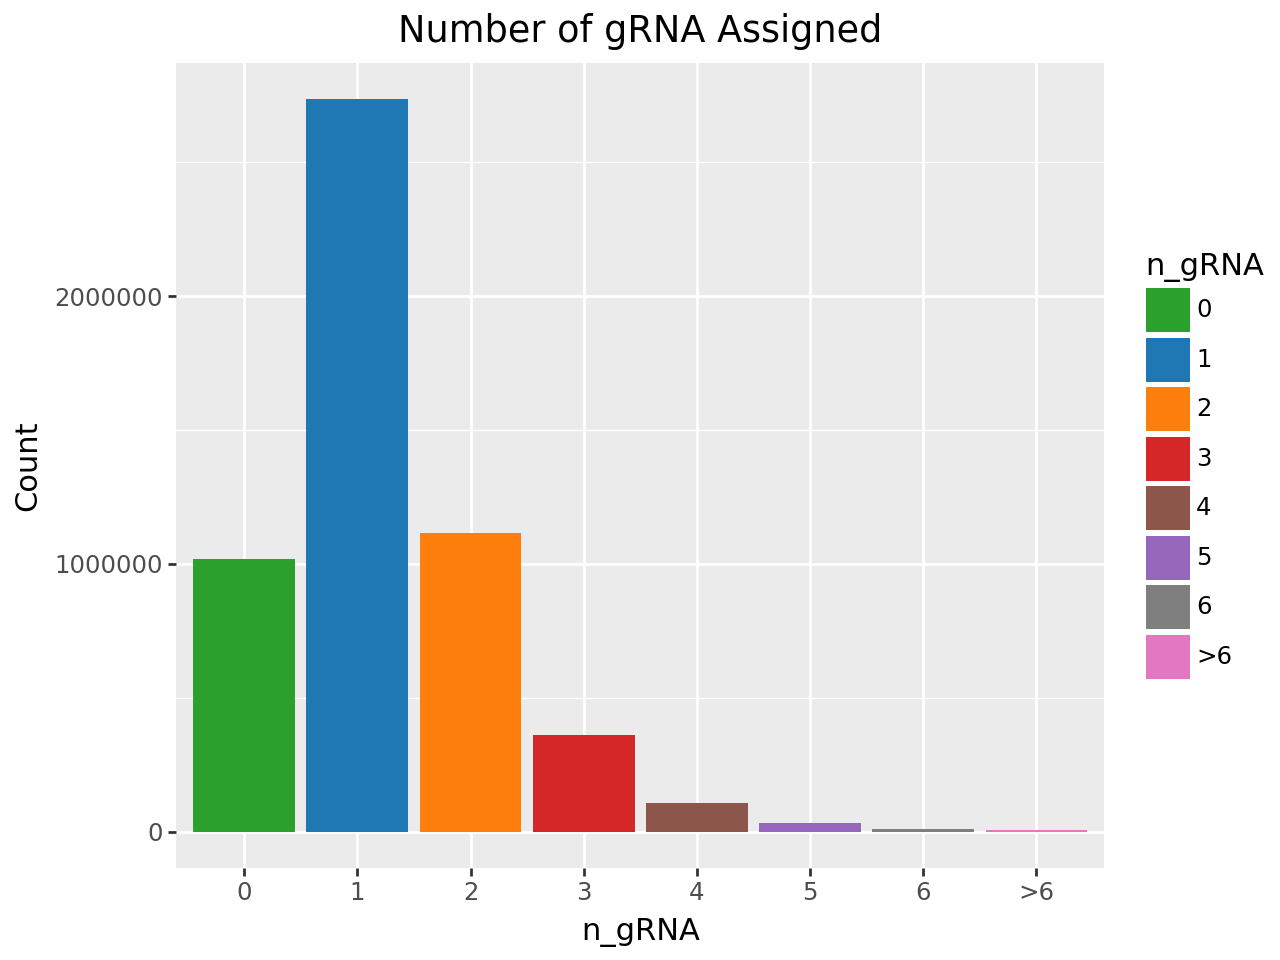

Cells without confident sgRNA calls: 18.89%
Estimated Multiplet Rate: 30.33%


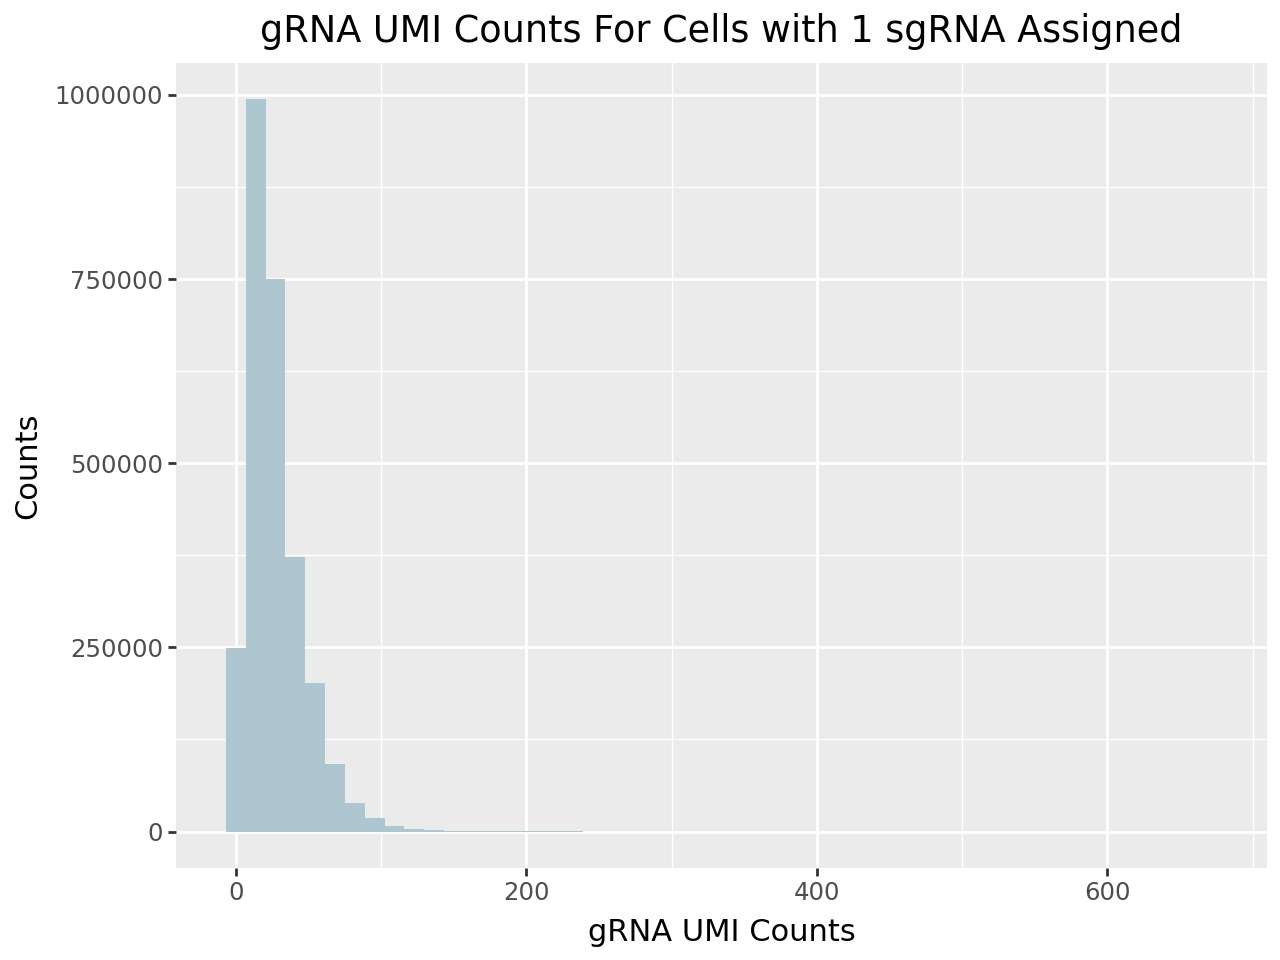

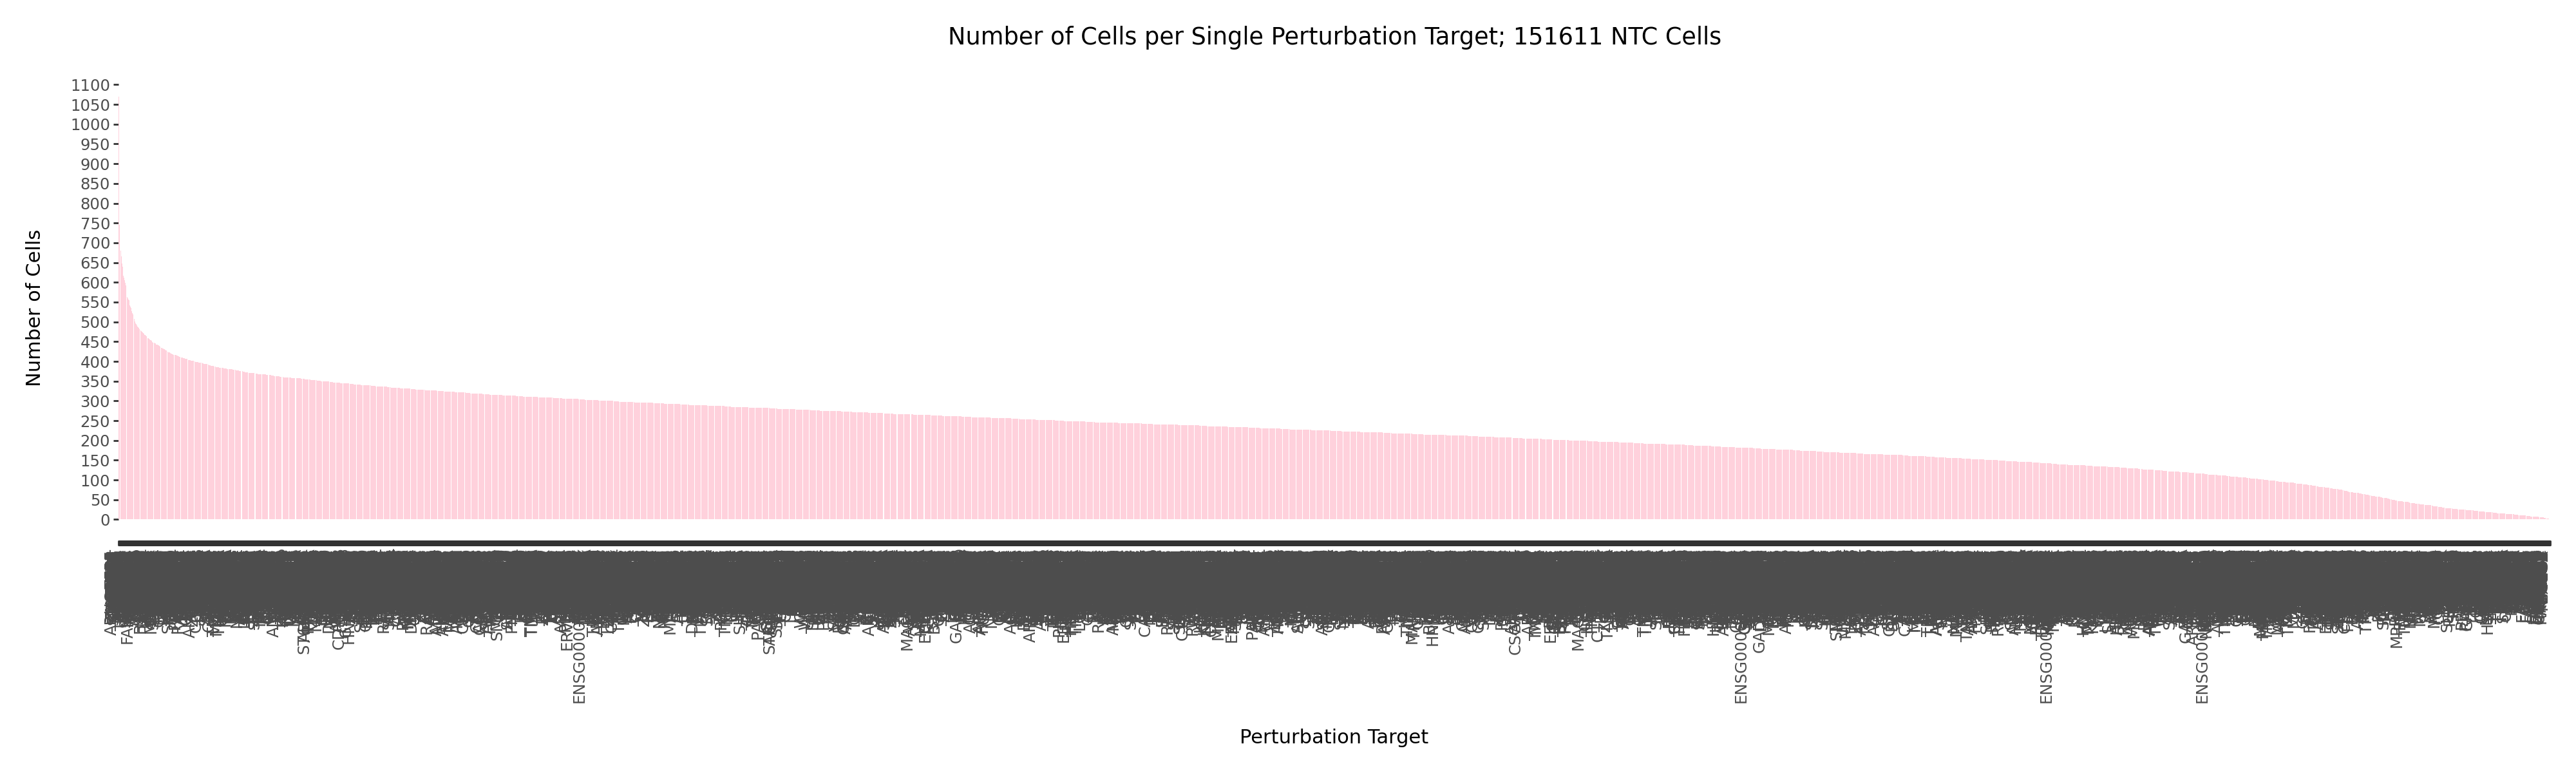

Number of perturbations with >= 50 cells with single guide assigned: 10933/11687 (93.55%)


In [ ]:
protospacer_calls_file_path = "/home/ranwyl/data_tf_project/protospacer_calls_per_cell.csv"
adata = qc.assign_protospacers(adata,protospacer_calls_file_path=protospacer_calls_file_path)

### Step C: Cell-level QC

Now we will run step C, cell-level QC. First, we assign metadata:

In [ ]:
aggregation_csv_file_path = "/home/ranwyl/data_tf_project/aggregation_csv.csv"
d = pd.read_csv(aggregation_csv_file_path)
channel_dict = {str(i+1):channel for i,channel in enumerate(d["sample_id"])}
adata = qc.assign_metadata(adata=adata,cell_type="KOLF2.1J iPSC",perturbation_type="CRISPRi Perturb-Seq",channel_dict=channel_dict)
adata.obs['n_gRNA_UMIs'] = adata.obs['n_gRNA_UMIs'].astype(str)

/home/ranwyl/data_tf_project/perturb_seq_heuristic_pipeline.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [ ]:
adata

AnnData object with n_obs × n_vars = 2735450 × 38606
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

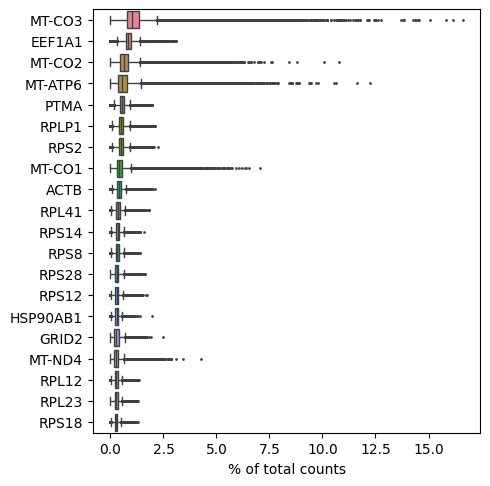

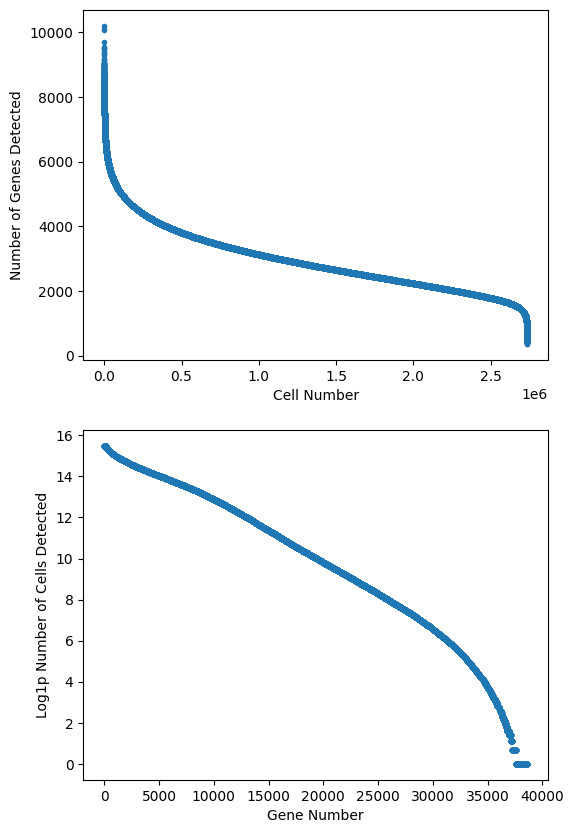

Removing 1039 genes not detected in any cells.


In [ ]:
adata = qc.general_qc(adata)

/home/ranwyl/data_tf_project/perturb_seq_heuristic_pipeline.py:201: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


outlier
False    2663490
True       71960
Name: count, dtype: int64

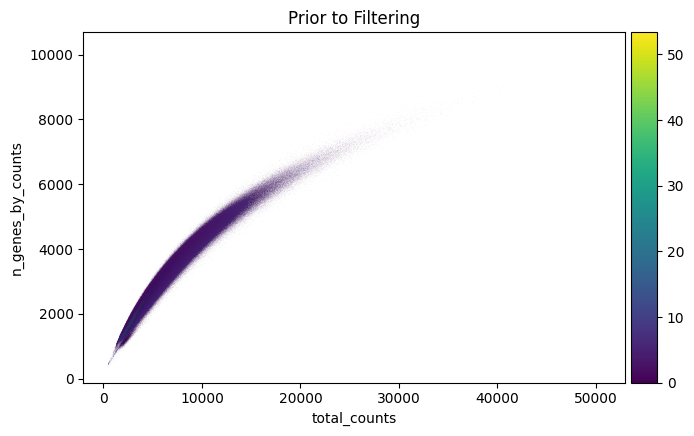

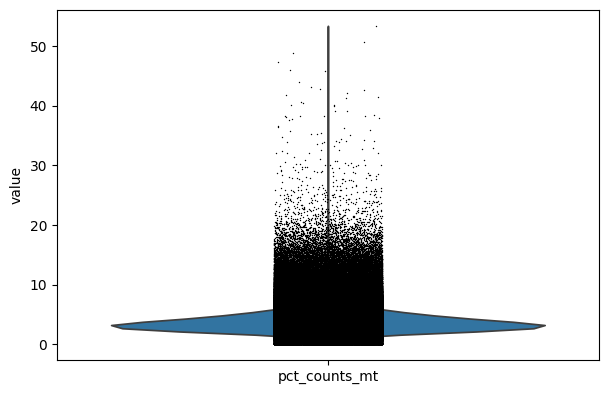

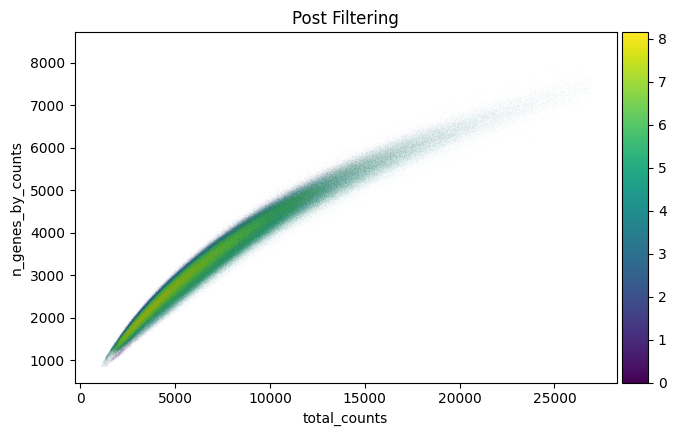

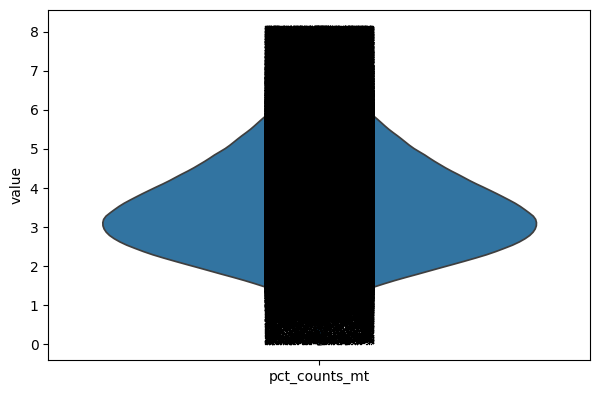

In [ ]:
adata = qc.dead_cell_qc(adata, mt_MADs=5)

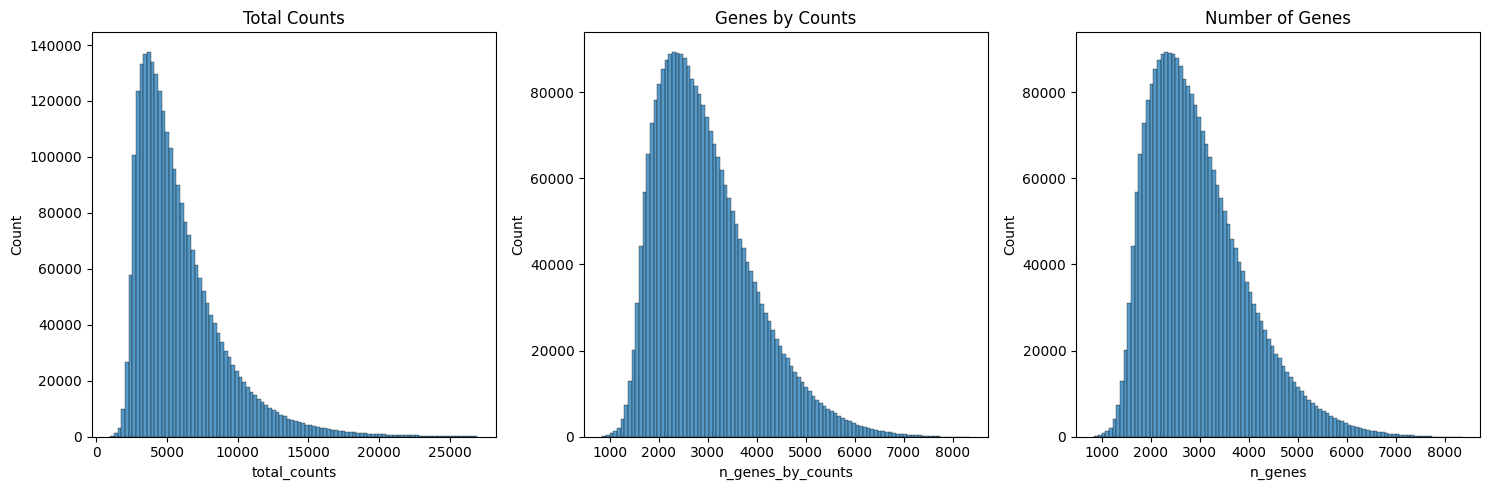

In [ ]:
qc.doublet_detection_sanity_check(adata)

Save the intermediate file:

In [ ]:
adata.write("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad") # Deleted already

### Step D: Isolating Core NTC Cells 

Read in QC-passed data:

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad")

Save raw counts and create `run` metadata column in `obs`:

In [ ]:
adata.layers["counts"] = adata.X.copy()
adata.obs["run"] = [label.split('-')[0] for label in adata.obs.channel]

Filter NTC cells based on provided whitelist:

In [ ]:
whitelist_filepath = "/home/ranwyl/data_tf_project/NTC_sgRNA_whitelist.txt"
with open(whitelist_filepath, 'r') as f:
  sgRNA_whitelist = f.read().splitlines()
ntc_adata = qc2._get_ntc_view(adata)
ntc_adata = ntc_adata[ntc_adata.obs.gRNA.isin(sgRNA_whitelist)].copy()
ntc_adata

AnnData object with n_obs × n_vars = 53476 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Use isolation forest with 30% contamination fraction to isolate core NTC cells:

Initial number of NTC Cells: 53476
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    342 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    300 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=100
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_r

  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:34)


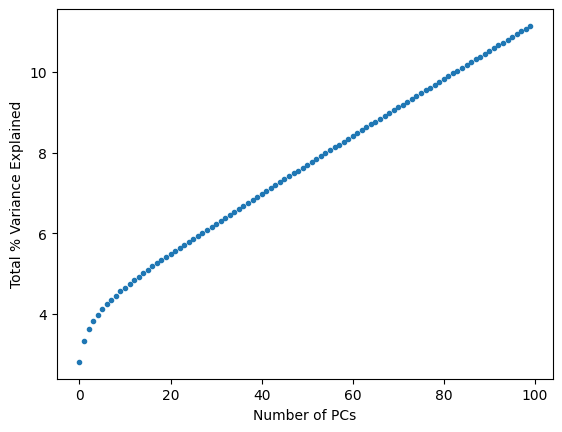

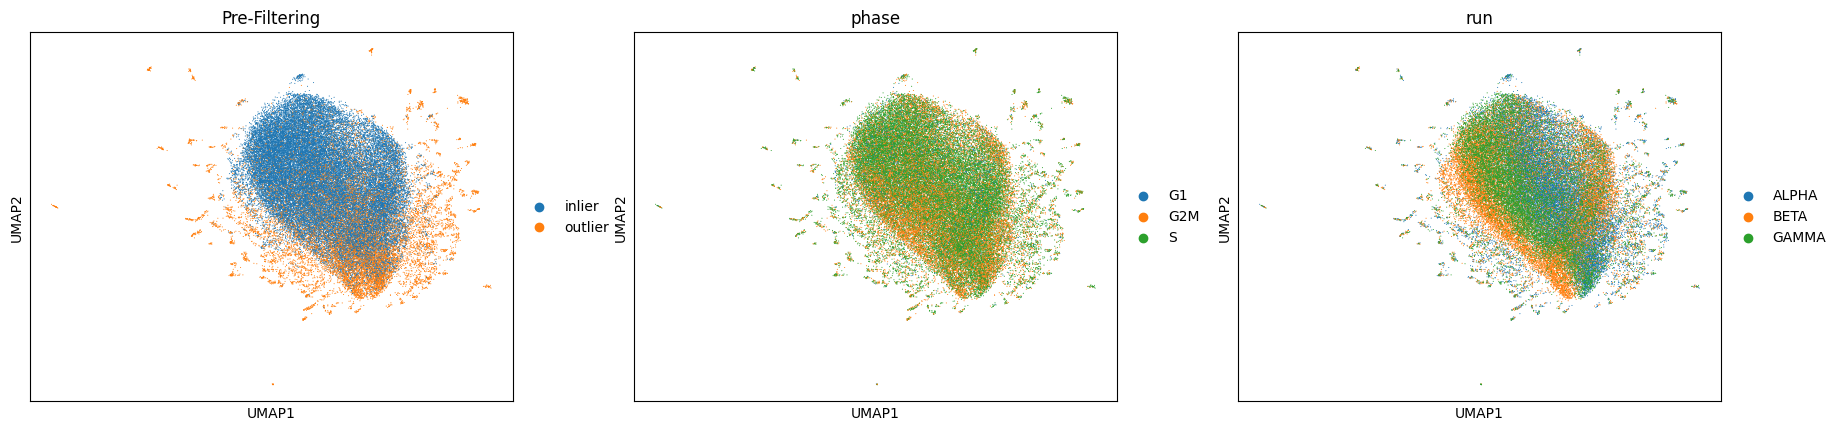

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


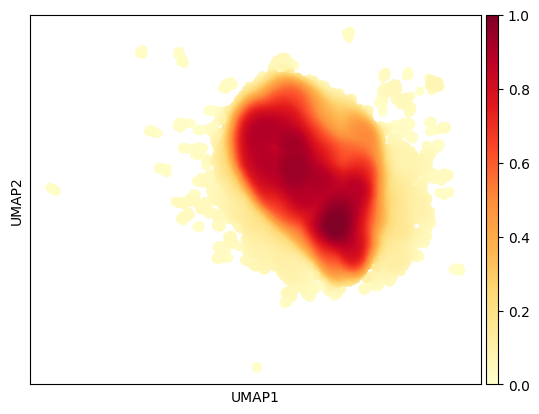

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:04)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:34)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


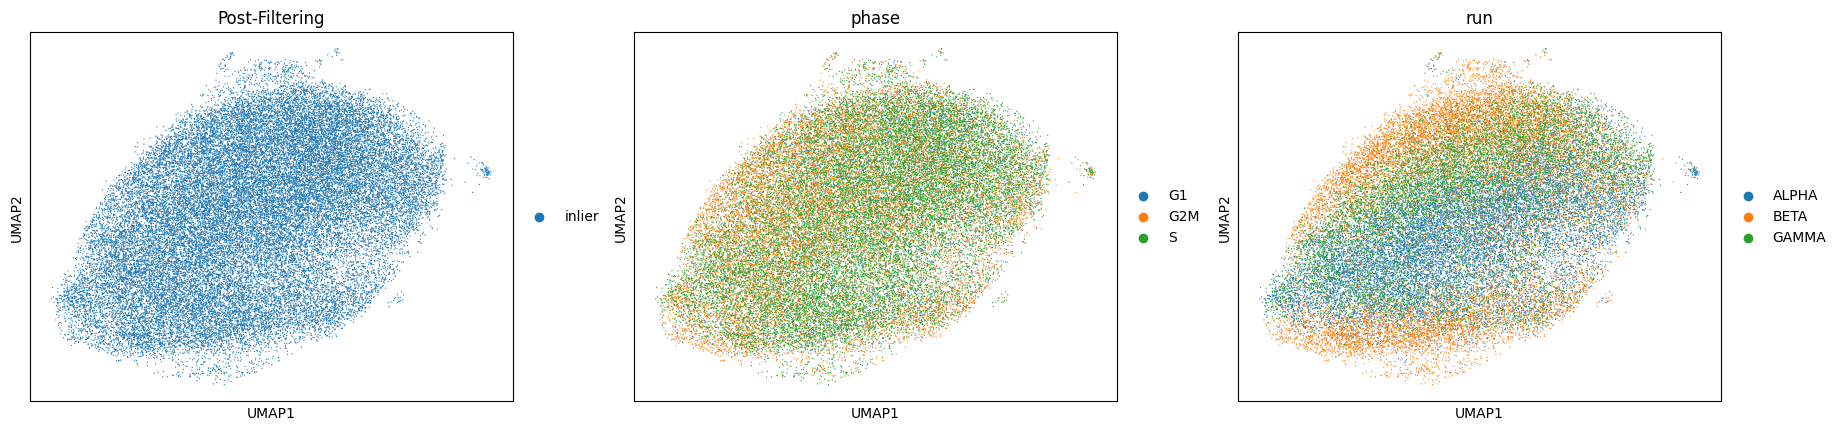

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


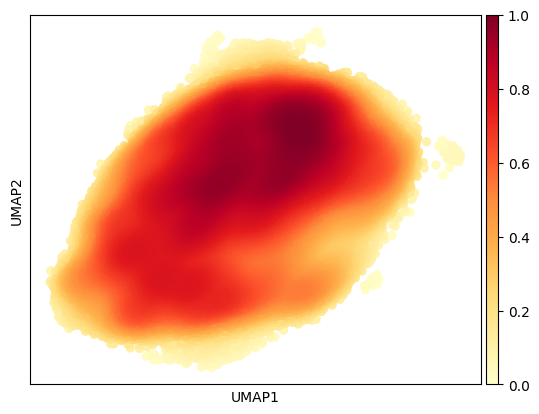

In [ ]:
ntc_adata = ntc_adata[ntc_adata.obs.index.isin(qc2.scrub_ntc(ntc_adata))]

In [ ]:
ntc_adata

View of AnnData object with n_obs × n_vars = 37433 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'S_score', 'G2M_score', 'phase', 'is_outlier', 'umap_density'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'is_outlier_colors', 'phase_colo

In [ ]:
ntc_adata.obs.run.value_counts()

run
ALPHA    14108
BETA     13537
GAMMA     9788
Name: count, dtype: int64

Note: the above counts are slightly different than the Pan_Genome_Analysis.ipynb notebook.

We have now isolated the core NTC cells. We will subset `adata` to only include perturbed cells and the core NTC cells.

In [ ]:
perturbed_mask = adata.obs.perturbed == "True"
valid_ntc_mask = adata.obs.index.isin(ntc_adata.obs.index)
adata_step_d = adata[perturbed_mask | valid_ntc_mask,:].copy()

In [ ]:
adata_step_d

AnnData object with n_obs × n_vars = 2554182 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Save the file:

In [ ]:
adata_step_d.write("/home/ranwyl/data_tf_project/Aggregate_Core_NTC.h5ad")

### Post step D/pre step E

Load in data:

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Core_NTC.h5ad")

Check that the number of NTC cells is correct:

In [ ]:
adata[adata.obs["perturbed"] == "False"]

View of AnnData object with n_obs × n_vars = 37433 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Plot cells per perturbation:

10281/11739 (87.58)% Perturbations have > 100 cells


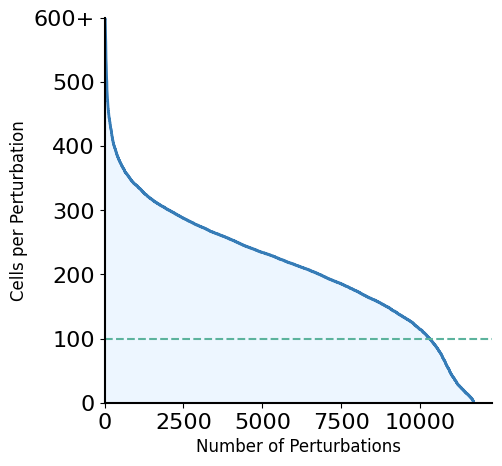

In [ ]:
f = qc2.plot_cells_per_perturbation(adata)

Plot UMIs per cell:

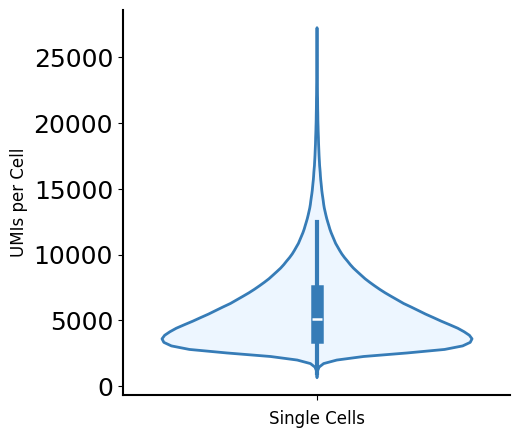

In [ ]:
f = qc2.plot_umis_per_cell(adata)

Assign more metadata:

In [ ]:
gene_id_file_path = "/home/ranwyl/data_tf_project/gene_ids.txt"
qc2.assign_gene_ids(adata, gene_id_file_path)
adata = qc2.remove_invalid_gene_targets_in_place(adata,obs_key="gene_target_ensembl_id",var_key="gene_ids")

  - ENSG00000234414
  - ENSG00000251380
  - ENSG00000182415
  - ENSG00000172288
  - ENSG00000262664
  - ENSG00000129864
  - ENSG00000268994
  - ENSG00000286190
  - ENSG00000253797


Split by run and save intermediate files:

In [ ]:
adata_alpha = adata[adata.obs.run=="ALPHA"]
adata_alpha = adata_alpha.copy()
adata_alpha.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA.h5ad")

In [ ]:
adata_beta = adata[adata.obs.run=="BETA"]
adata_beta = adata_beta.copy()
adata_beta.write("/home/ranwyl/data_tf_project/Aggregate_BETA.h5ad")

In [ ]:
adata_gamma = adata[adata.obs.run=="GAMMA"]
adata_gamma = adata_gamma.copy()
adata_gamma.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA.h5ad")

### Step E: Isolating effective sgRNA

In this step, we will normalize counts per cell to 1M, remove sgRNA that do not induce mean >30% on-target knockdown, and remove unrepressed cells and sgRNA without at least 25 associated cells. We will read in each dataset and perform the knockdown QC one at a time.

Perform knockdown QC:

normalizing counts per cell
    finished (0:00:13)


/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


8192 out of 11304 (72.47%) non-NTC sgRNAs have more than 30% knockdown.


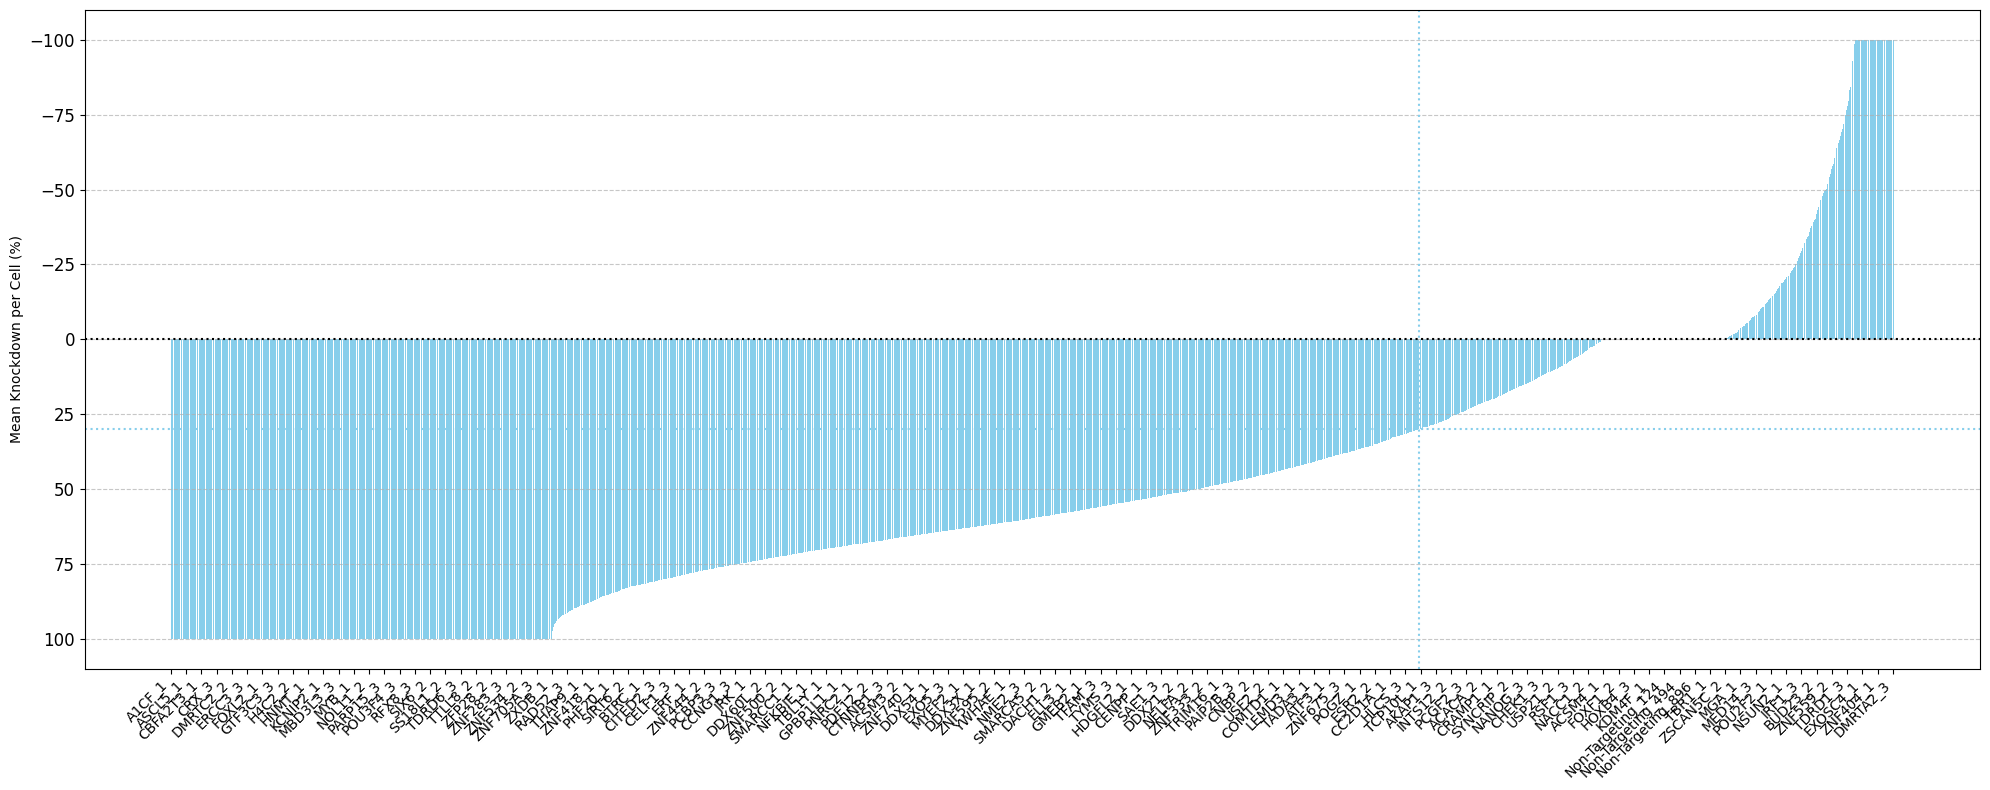

Removing 2876 perturbing sgRNA for not having more than 30% knockdown
Before filter: 11307,perturbed
True     887720
False     14108
Name: count, dtype: int64
After filter: 8431,perturbed
True     663159
False     14108
Name: count, dtype: int64
Removing 41501 perturbed cells for not having any measureable repression.
Before filter: 8431,perturbed
True     663159
False     14108
Name: count, dtype: int64
After filter: 8431,perturbed
True     621658
False     14108
Name: count, dtype: int64


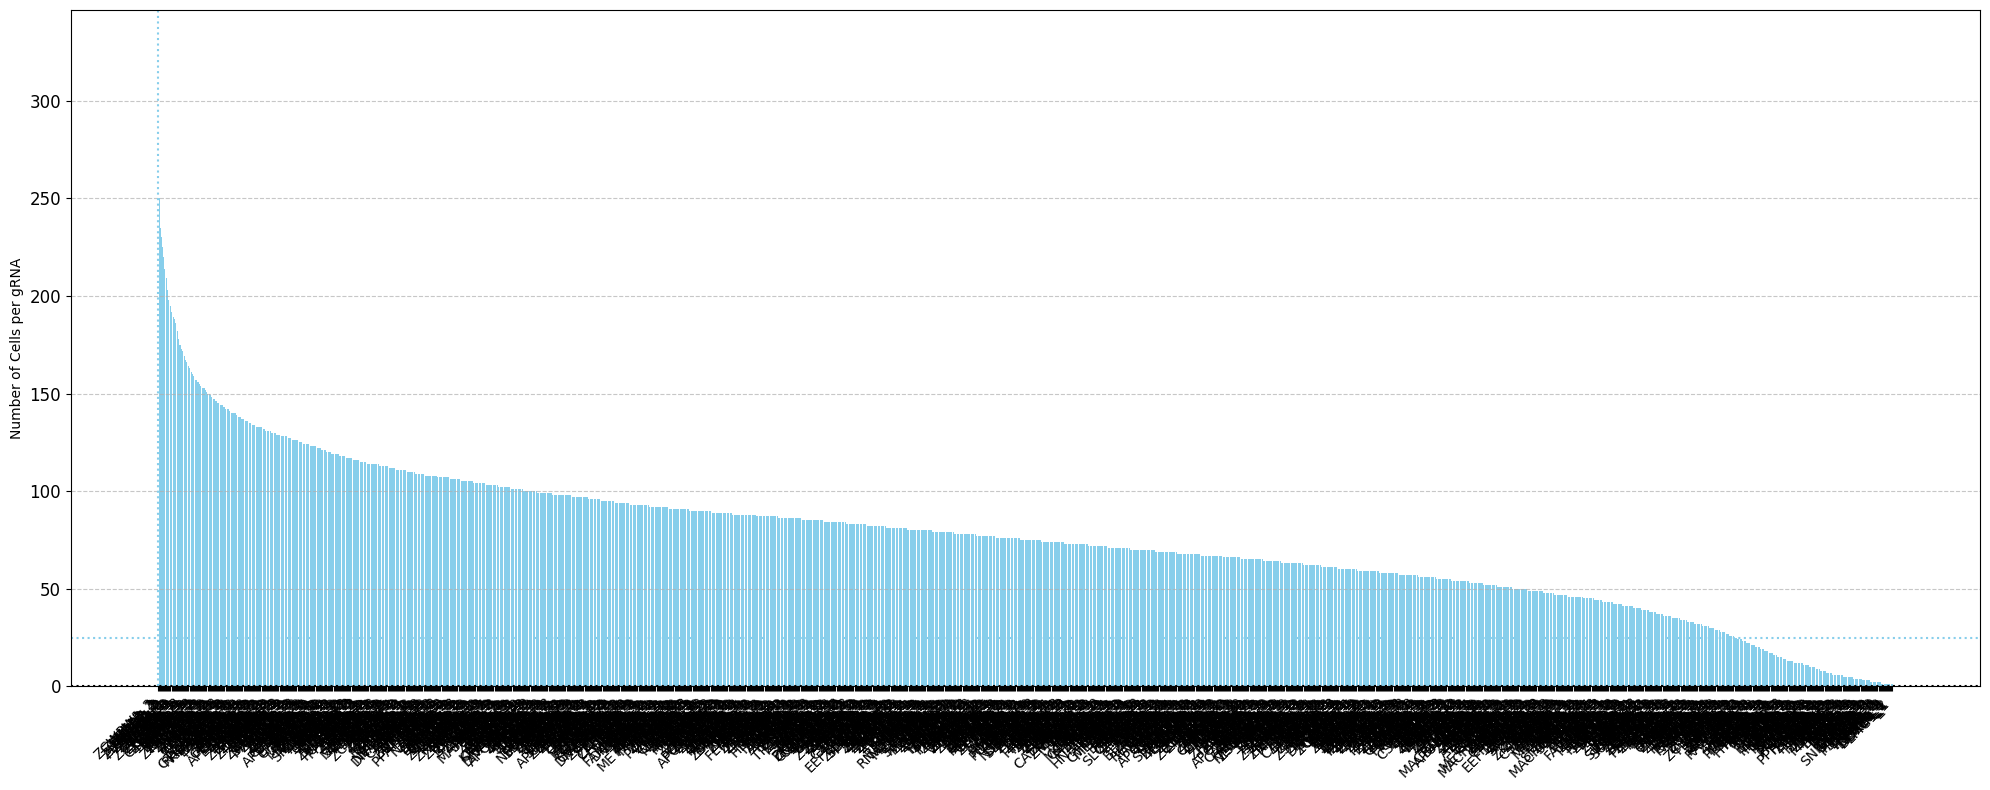

Before filter: 8431,perturbed
True     621658
False     14108
Name: count, dtype: int64
Removing 754 perturbing sgRNA for not having more than 25 cells
After filter: 7677,perturbed
True     613603
False     14108
Name: count, dtype: int64


In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA.h5ad")
knockdown_adata_alpha = qc2.knockdown_qc(adata_alpha, 'gene_target_ensembl_id', 'gene_ids').copy()

normalizing counts per cell
    finished (0:00:18)


/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


9799 out of 12155 (80.62%) non-NTC sgRNAs have more than 30% knockdown.


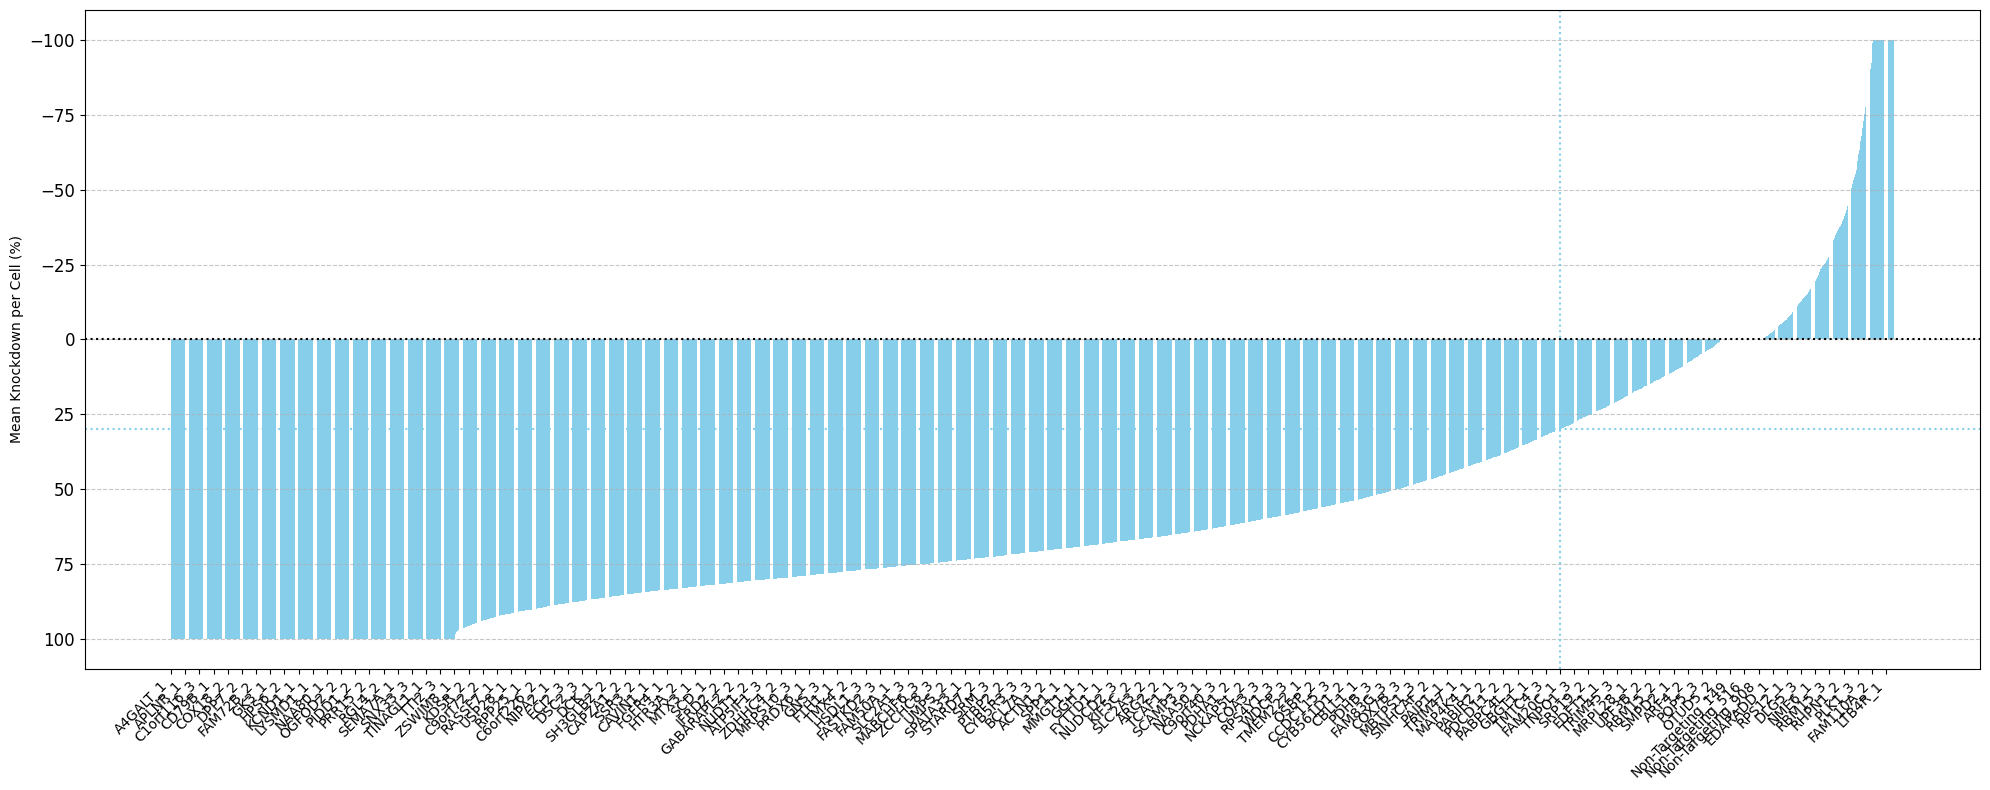

Removing 2120 perturbing sgRNA for not having more than 30% knockdown
Before filter: 12155,perturbed
True     948581
False     13537
Name: count, dtype: int64
After filter: 10035,perturbed
True     807083
False     13537
Name: count, dtype: int64
Removing 44923 perturbed cells for not having any measureable repression.
Before filter: 10035,perturbed
True     807083
False     13537
Name: count, dtype: int64
After filter: 10035,perturbed
True     762160
False     13537
Name: count, dtype: int64


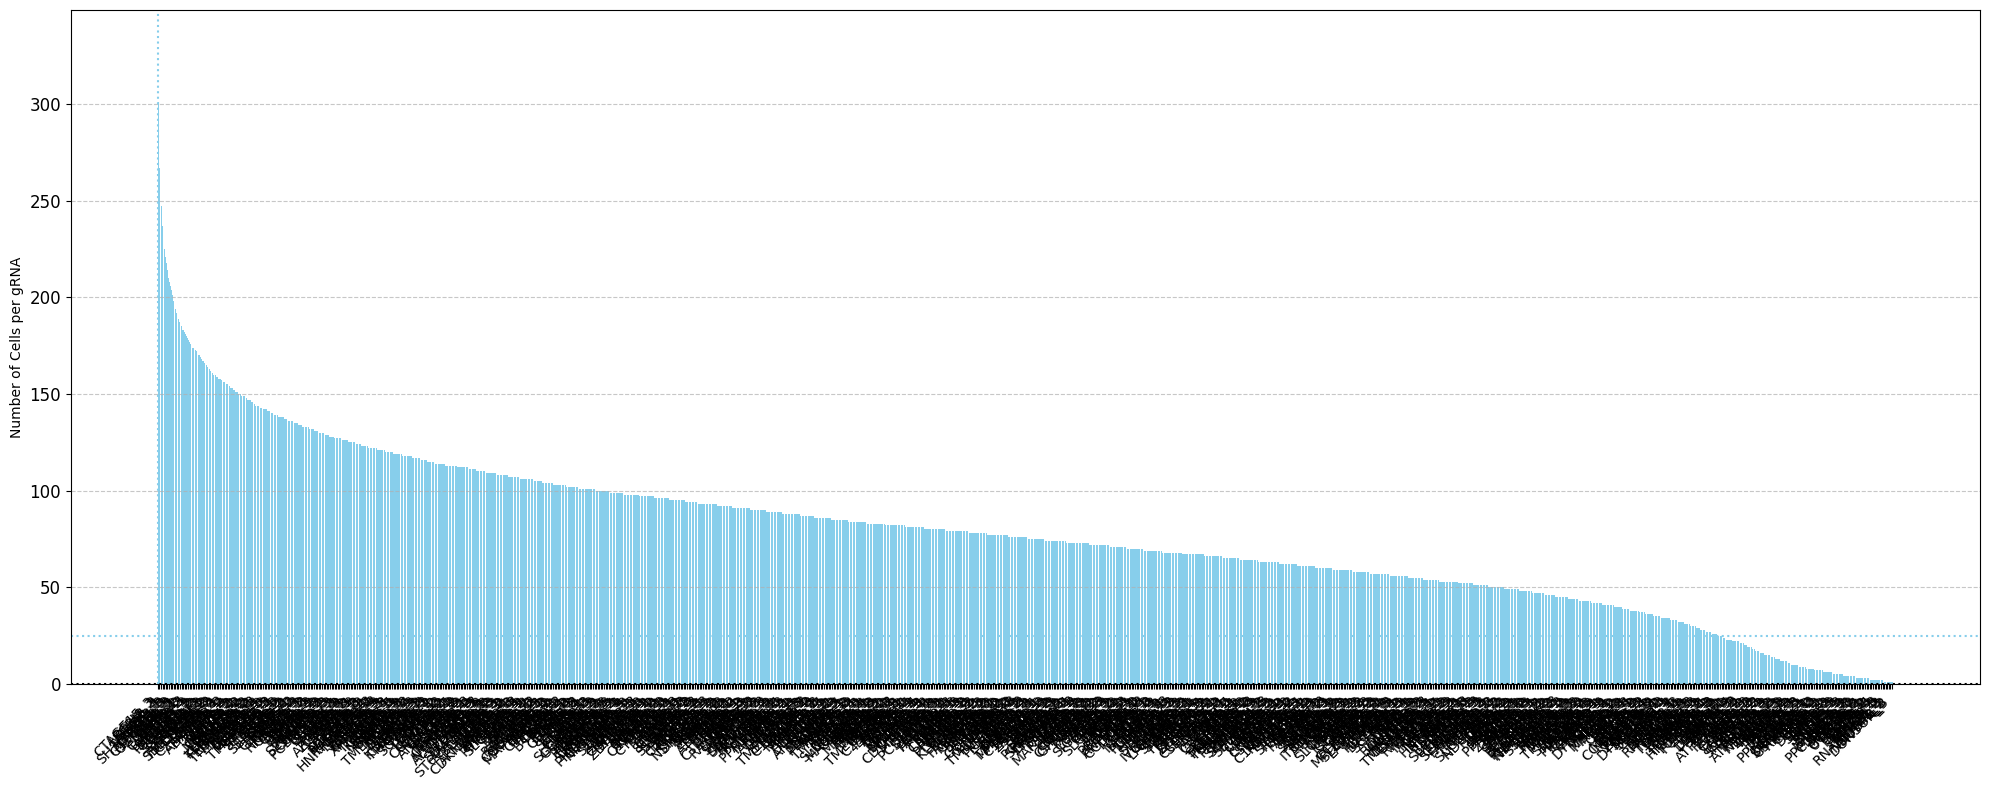

Before filter: 10035,perturbed
True     762160
False     13537
Name: count, dtype: int64
Removing 995 perturbing sgRNA for not having more than 25 cells
After filter: 9040,perturbed
True     751795
False     13537
Name: count, dtype: int64


In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA.h5ad")
knockdown_adata_beta = qc2.knockdown_qc(adata_beta, 'gene_target_ensembl_id', 'gene_ids').copy()

normalizing counts per cell
    finished (0:00:12)


/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


9888 out of 12002 (82.39%) non-NTC sgRNAs have more than 30% knockdown.


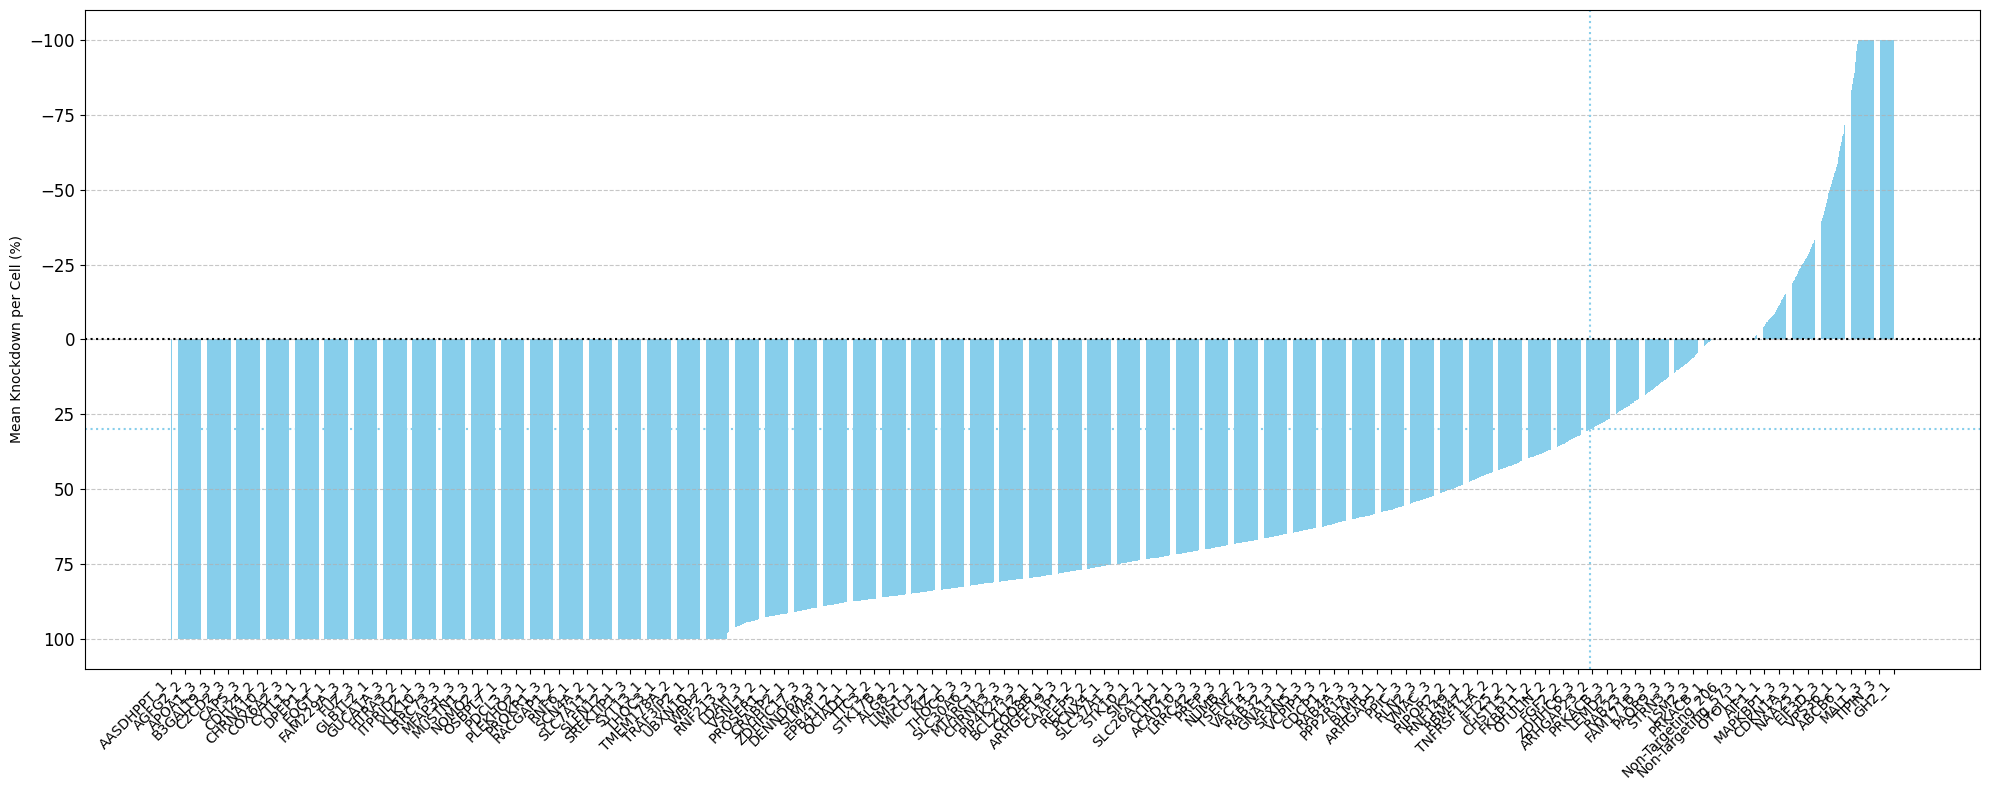

Removing 1879 perturbing sgRNA for not having more than 30% knockdown
Before filter: 12002,perturbed
True     678499
False      9788
Name: count, dtype: int64
After filter: 10123,perturbed
True     575298
False      9788
Name: count, dtype: int64
Removing 24979 perturbed cells for not having any measureable repression.
Before filter: 10123,perturbed
True     575298
False      9788
Name: count, dtype: int64
After filter: 10123,perturbed
True     550319
False      9788
Name: count, dtype: int64


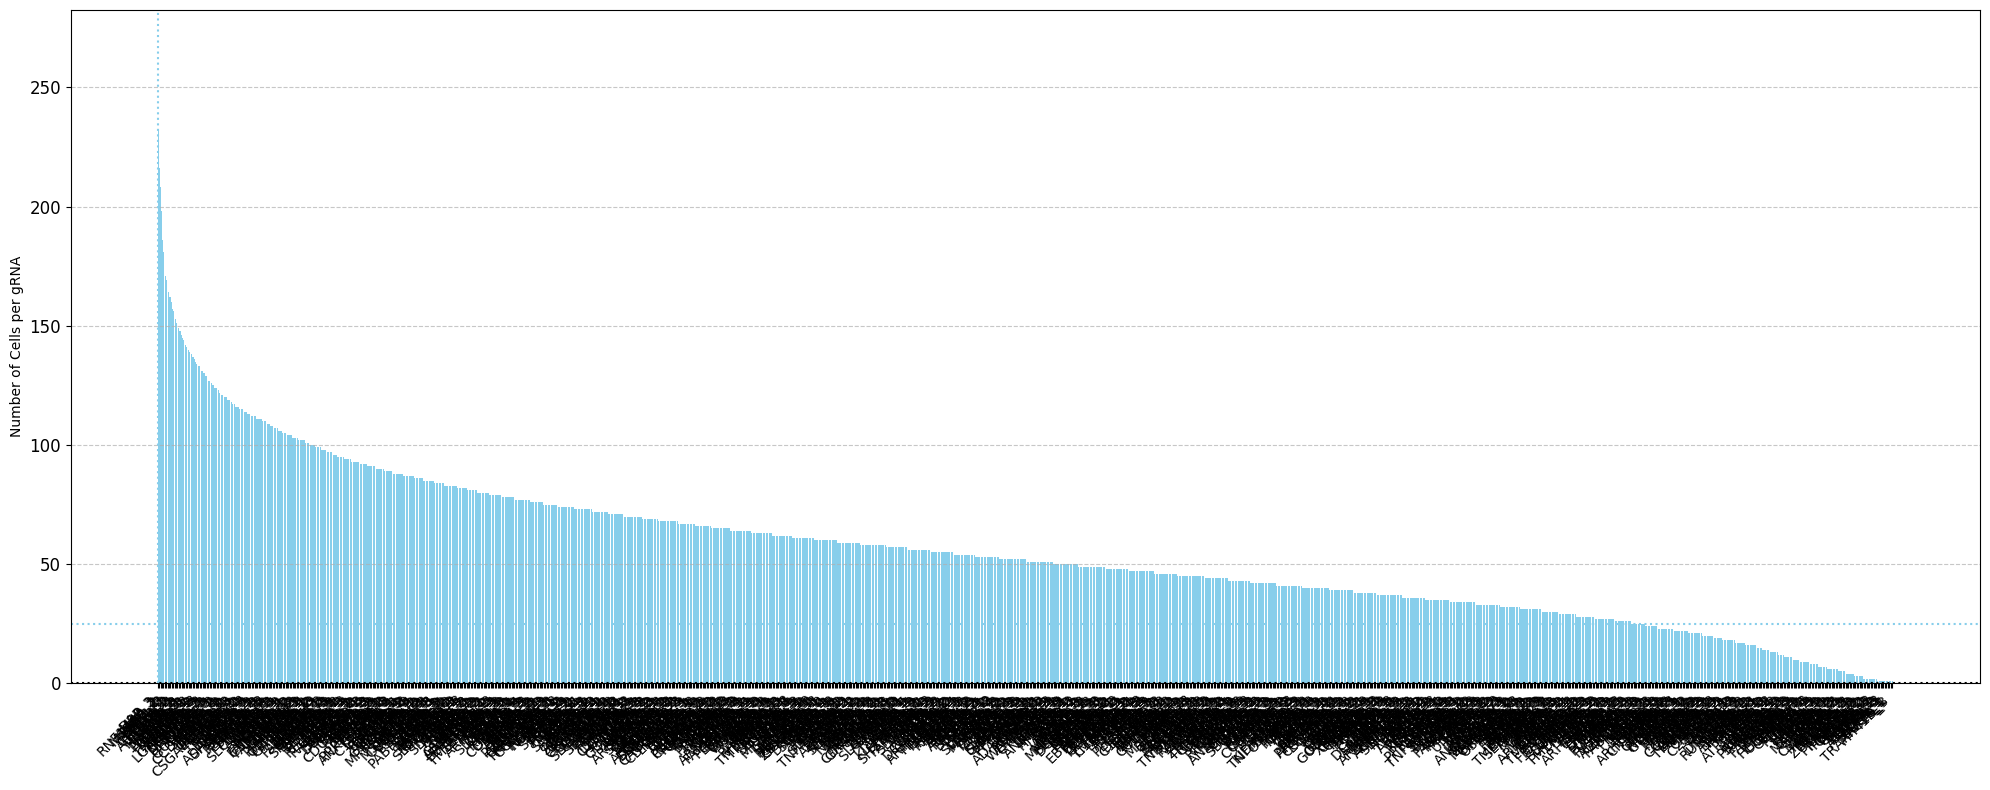

Before filter: 10123,perturbed
True     550319
False      9788
Name: count, dtype: int64
Removing 1493 perturbing sgRNA for not having more than 25 cells
After filter: 8630,perturbed
True     529985
False      9788
Name: count, dtype: int64


In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA.h5ad")
knockdown_adata_gamma = qc2.knockdown_qc(adata_gamma, 'gene_target_ensembl_id', 'gene_ids').copy()

/tmp/ipykernel_3415299/3623594956.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_3415299/3623594956.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


9530/11739 (0.8118238350796491) Perturbations achieve > 30% Knockdown


/tmp/ipykernel_3415299/3623594956.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


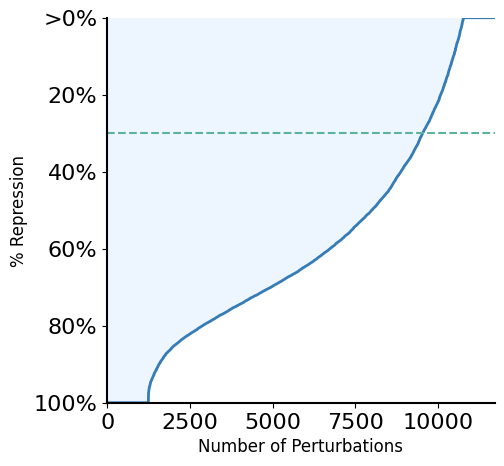

In [ ]:
alpha_knockdown = list(qc2._get_perturbed_view(adata_alpha).obs.groupby("gene_target")["target_knockdown"].mean())
beta_knockdown = list(qc2._get_perturbed_view(adata_beta).obs.groupby("gene_target")["target_knockdown"].mean())
gamma_knockdown = list(qc2._get_perturbed_view(adata_gamma).obs.groupby("gene_target")["target_knockdown"].mean())
total_knockdown = np.sort(np.clip(np.array(alpha_knockdown + beta_knockdown + gamma_knockdown),a_min=0,a_max=1))[::-1]
f = qc2.plot_percentage_perturbations_by_repression(total_knockdown)

In [ ]:
print(sum(total_knockdown > 0.3)/11739)

0.8118238350796491


Calculate median NTC number of UMI counts:

In [ ]:
median_NTC = np.median(list(qc2._get_ntc_view(knockdown_adata_alpha).obs.n_UMI_counts) 
                       + list(qc2._get_ntc_view(knockdown_adata_beta).obs.n_UMI_counts) 
                       + list(qc2._get_ntc_view(knockdown_adata_gamma).obs.n_UMI_counts))
print(median_NTC)

4542.0


In [ ]:
median_NTC = 4542.0

Normalize, log1p transform, and scale data with target sum `median_NTC`, one dataset at a time.

ALPHA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_alpha,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_alpha)
sc.pp.scale(knockdown_adata_alpha)

normalizing counts per cell
    finished (0:00:12)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_alpha.write("/home/ranwyl/data_tf_project/step_E_output_ALPHA.h5ad")

BETA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_beta,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_beta)
sc.pp.scale(knockdown_adata_beta)

normalizing counts per cell
    finished (0:00:10)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_beta.write("/home/ranwyl/data_tf_project/step_E_output_BETA.h5ad")

GAMMA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_gamma,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_gamma)
sc.pp.scale(knockdown_adata_gamma)

normalizing counts per cell
    finished (0:00:06)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_gamma.write("/home/ranwyl/data_tf_project/step_E_output_GAMMA.h5ad")

### Step F: Isolate sgRNA altering cell state and isolate perturbed cells

First we perform sgRNA level energy distance based filtering on each of the 3 data subsets.

In [ ]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

ALPHA:

In [ ]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA.h5ad")

/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:519: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:36)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)


Computing null distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/7442 [00:00<?, ?it/s]

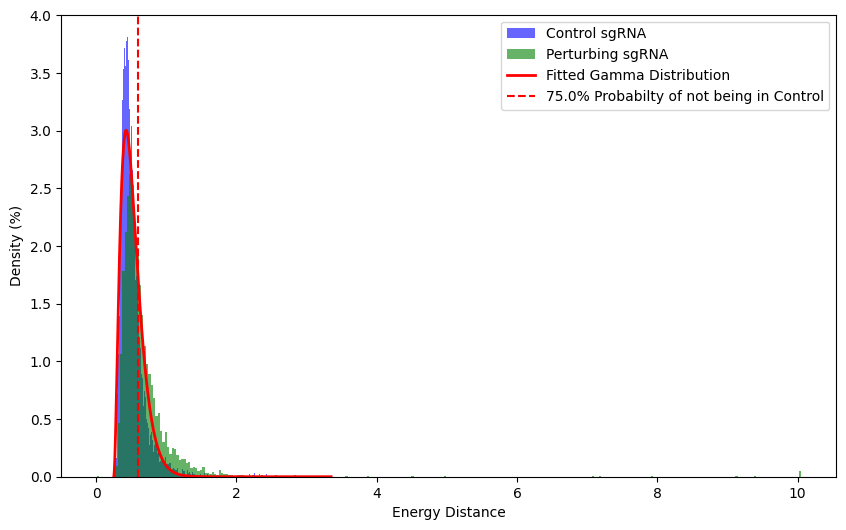

3211/7442 Perturbing sgRNA cross threshold of 0.75


In [ ]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA(knockdown_adata_alpha)

In [ ]:
alpha_filtered = alpha_filtered.copy()

In [ ]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered.h5ad")

BETA:

In [ ]:
knockdown_adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA.h5ad")

/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:519: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:10)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:42)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:45)


Computing null distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8805 [00:00<?, ?it/s]

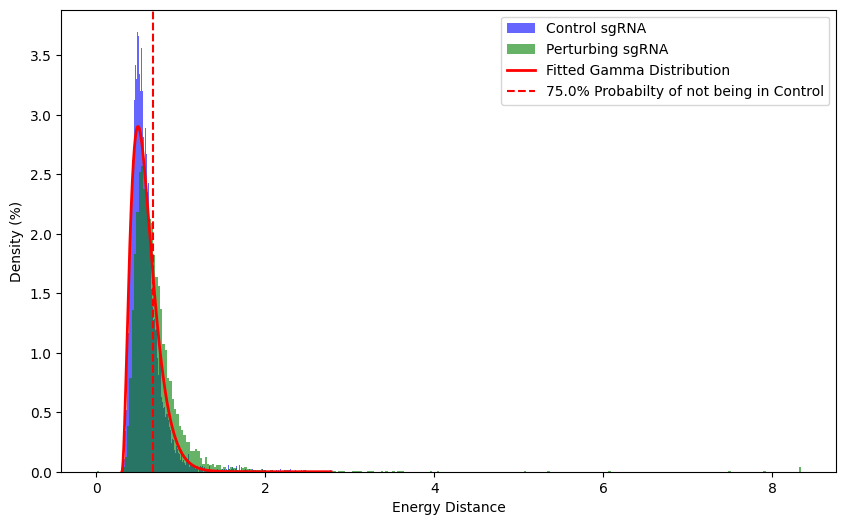

3714/8805 Perturbing sgRNA cross threshold of 0.75


In [ ]:
beta_filtered, beta_null_distances, beta_results = qc2.filter_sgRNA(knockdown_adata_beta)

In [ ]:
beta_filtered = beta_filtered.copy()

In [ ]:
beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered.h5ad")

GAMMA:

In [ ]:
knockdown_adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA.h5ad")

/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:519: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:09)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:38)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:41)


Computing null distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8396 [00:00<?, ?it/s]

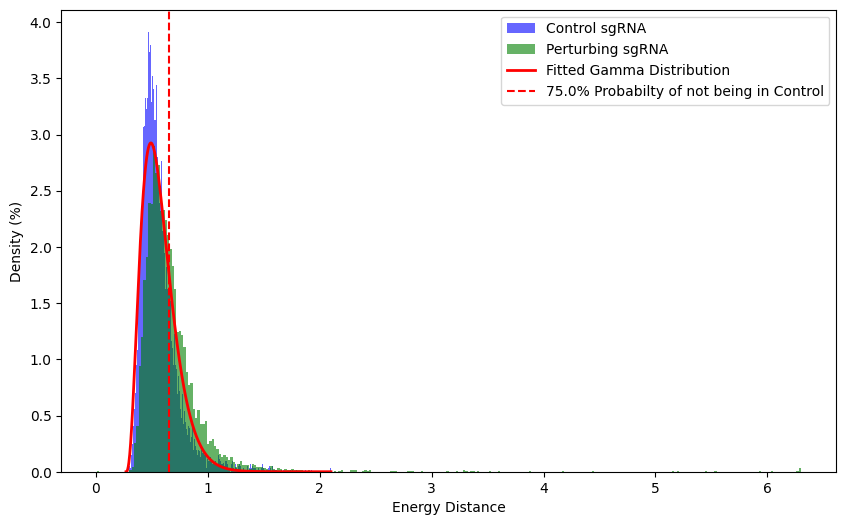

3383/8396 Perturbing sgRNA cross threshold of 0.75


In [ ]:
gamma_filtered, gamma_null_distances, gamma_results = qc2.filter_sgRNA(knockdown_adata_gamma)

In [ ]:
gamma_filtered = gamma_filtered.copy()

In [ ]:
gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered.h5ad")

Next, we remove unperturbed cells one data subset at a time.

ALPHA:

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered.h5ad")

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:03)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


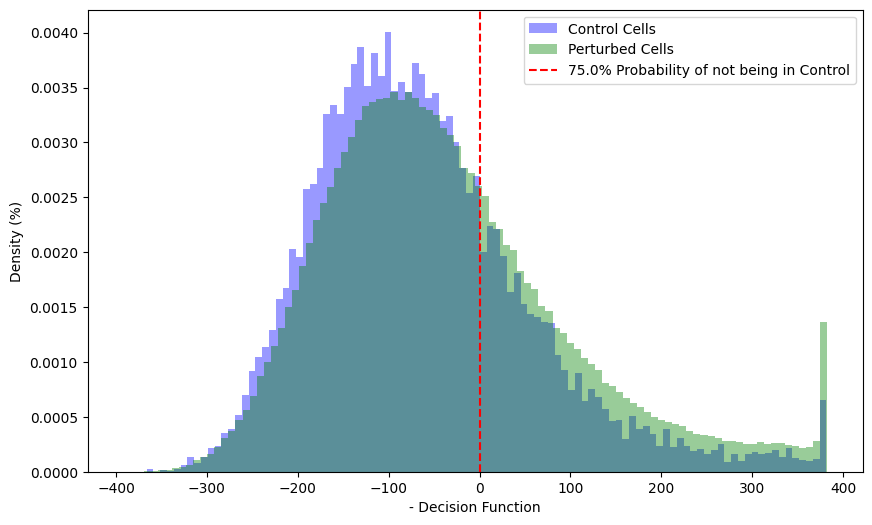

83534/258747 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells(adata_alpha, threshold=0.75)

In [ ]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1467 ['NTC', 'KAT2A', 'ZFP41', 'ARHGAP35', 'LRPPRC', 'DNMT1', 'CABIN1', 'ZNF354A', 'BHLHE40', 'EMSY', 'CHAMP1', 'EHMT1', 'PCGF1', 'PWWP2B', 'SMAD9', 'MEIS3', 'ELOC', 'HASPIN', 'PNPT1', 'HMCES', 'FOXH1', 'EZH2', 'TFAM', 'SIN3B', 'EHMT2', 'SHOX2', 'HMGB4', 'RNASEH1', 'ZBTB22', 'ALKBH1', 'METTL18', 'ZNF383', 'SMARCC1', 'ZNF521', 'SMARCE1', 'UHRF1', 'ZNF787', 'SLF1', 'DDX6', 'COMTD1', 'FOXS1', 'ACTB', 'ZNF75D', 'ETS1', 'ZNF219', 'PCGF6', 'ZFP1', 'POU5F1', 'NEK9', 'ZFP69B', 'SKP2', 'SOX4', 'NABP2', 'PDP1', 'POLRMT', 'ZNF462', 'LEMD3', 'EYA3', 'NEUROD4', 'SUZ12', 'MTA1', 'DOT1L', 'NANOG', 'ETV1', 'ESRRA', 'ZNF394', 'SLX1A', 'GATA2', 'TBX20', 'ZNF791', 'H2AC11', 'CARNMT1', 'THAP12', 'POGZ', 'ZNF419', 'TENT4B', 'ERVK3-1', 'NFIL3', 'KLF6', 'RLIM', 'FOXJ2', 'SETDB1', 'EPAS1', 'TIGD2', 'CRTC2', 'ZKSCAN1', 'H2BW2', 'KMT2D', 'FOXO3B', 'ZNF418', 'SMAD4', 'BARX1', 'PURG', 'RCOR2', 'ZNF180', 'SHOX', 'TWIST1', 'BCL6B', 'DIS3L', 'PPCS', 'MSX2', 'TRMT10C', 'E2F4', 'HES6', 'RORC', 'ZNF20', 'TP53BP1', 'BRP

In [ ]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 739 perturbations for having under 25 cells.


In [ ]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")

BETA:

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered.h5ad")

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:04)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:21)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


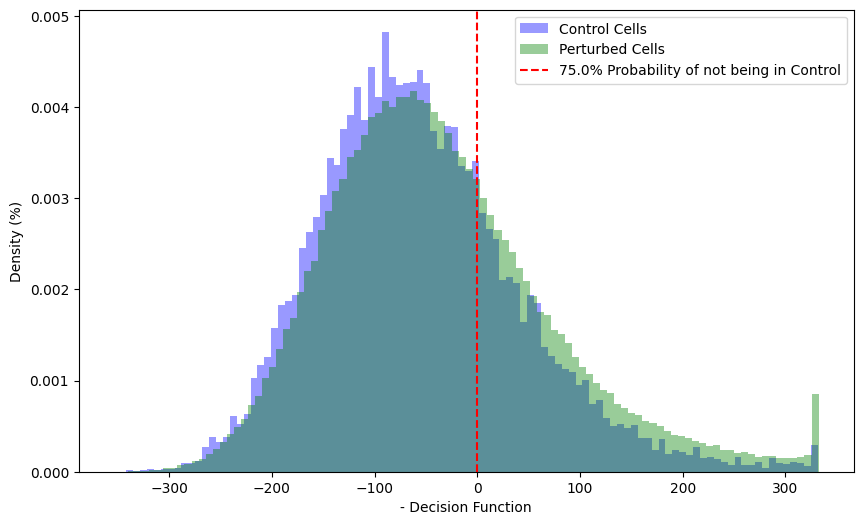

95740/306162 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells(adata_beta, threshold=0.75)

In [ ]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1696 ['NTC', 'SCAF4', 'CASP6', 'LATS2', 'BBC3', 'HCCS', 'IKBIP', 'UBFD1', 'FBXO45', 'VHL', 'JOSD1', 'VPS33A', 'UBE2M', 'RHOG', 'TESK1', 'SLC30A1', 'ETNK2', 'NAE1', 'CTAGE15', 'SGSM3', 'ACOT8', 'DSTN', 'CYCS', 'PPP1R14B', 'NCKAP5L', 'ARFRP1', 'FZD9', 'CASP3', 'IPO9', 'OSBPL2', 'BAX', 'SENP5', 'ATPAF1', 'MRPL36', 'LAMTOR1', 'YPEL3', 'TXNDC12', 'CHGA', 'LAMTOR5', 'POGLUT3', 'CLDN3', 'ACTN1', 'PACSIN1', 'CDKN2AIPNL', 'TPST2', 'MTRF1L', 'CCDC6', 'MZT2A', 'SH3BGRL3', 'ARFGAP1', 'ART5', 'C1orf159', 'CLPTM1L', 'IRAK1', 'FBXO44', 'SPRY2', 'CAPRIN2', 'CDK5R1', 'PPP1R1A', 'GRPEL2', 'IFNGR1', 'ZFPL1', 'PODXL2', 'SLC39A1', 'CAPN1', 'TWSG1', 'SLC35F6', 'FAM120AOS', 'LYSMD3', 'POLDIP2', 'DUS4L', 'TMSB4Y', 'ATAD1', 'MOSPD1', 'TCAF1', 'CLUH', 'VPS39', 'TEFM', 'FADS1', 'SLC30A5', 'KHDC4', 'MTCH1', 'SLC39A13', 'TOE1', 'VKORC1', 'GPR137', 'IFFO1', 'FJX1', 'SLC29A1', 'CAVIN1', 'LZTS2', 'FAM210B', 'WBP1', 'PTPN1', 'MRPL24', 'LIMD2', 'DPH2', 'TM6SF2', 'SNCG', 'LRCH4', 'FNDC10', 'CCDC78', 'STEAP3', 'BCKDK', '

In [ ]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 800 perturbations for having under 25 cells.


In [ ]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")

GAMMA:

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered.h5ad")

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:15)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


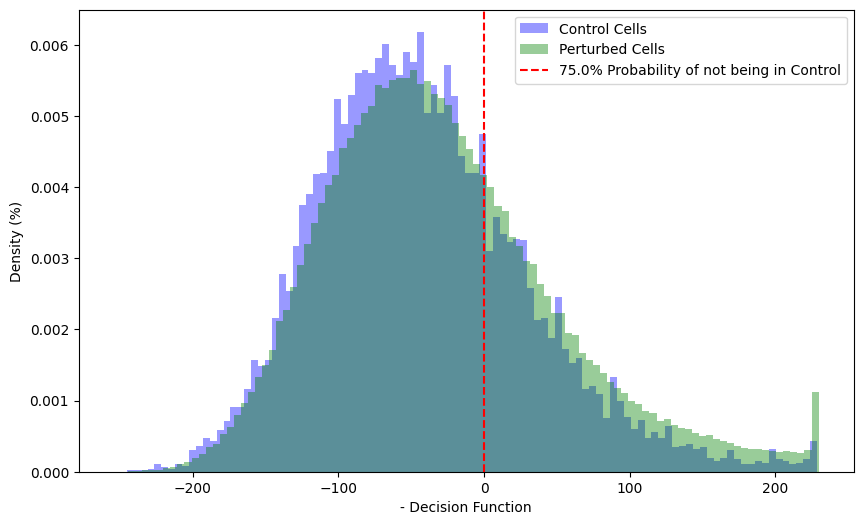

62877/205929 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells(adata_gamma, threshold=0.75)

In [ ]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1070 ['NTC', 'SUPT20H', 'FLYWCH2', 'FAM193A', 'DDT', 'RNF144A', 'NF2', 'FLCN', 'ENTPD8', 'HS2ST1', 'SCARB1', 'CNST', 'HCN2', 'RALGAPB', 'TIMM50', 'MMP16', 'CTAGE15', 'IL17RD', 'EIF4ENIF1', 'RASA2', 'WDR37', 'DRD4', 'FBXO31', 'CEP43', 'TGFBR2', 'RBM5', 'C1orf21', 'TEX2', 'STK10', 'TMEM74B', 'DENND1C', 'FAM241B', 'CRIM1', 'RAB8B', 'KLHL24', 'C3orf52', 'KCNF1', 'CEP78', 'PUS1', 'HIPK2', 'STOML1', 'RGPD5', 'PARD6G', 'PIP4P2', 'KIF17', 'NUAK2', 'MCOLN1', 'MMRN2', 'NRBP1', 'CFP', 'CACUL1', 'PDZD8', 'TBC1D7', 'AGTPBP1', 'YPEL1', 'ANXA2', 'CTAGE4', 'PAQR3', 'CLPSL2', 'ABCG1', 'PON2', 'DNAJB5', 'FAM200B', 'PEX13', 'HMCN2', 'MTPAP', 'GOLGA4', 'BTBD10', 'DTX1', 'ANXA6', 'MRRF', 'MLYCD', 'SYAP1', 'DAP', 'TBK1', 'TMEM179B', 'TRABD', 'DNAJC28', 'GRSF1', 'SLC17A7', 'FAM117B', 'SPATA25', 'UNC5B', 'LAMC3', 'CAPNS1', 'BEST4', 'BLTP3B', 'MAP4K2', 'SULF2', 'RET', 'BPGM', 'CYP2D6', 'CCDC28B', 'PCMTD1', 'GOLT1A', 'DENND4B', 'SPAG9', 'MADD', 'ANKRD17', 'CCER2', 'RNF7', 'EFNB3', 'BCL2L12', 'MAEA', 'ITPRID2', 

In [ ]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1331 perturbations for having under 25 cells.


In [ ]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

### Modifying and testing code for Step G

3/12:
-  Started with 12GB RAM used
-  Then read in `adata_alpha`, usage = 28GB (so `adata_alpha` uses 16GB RAM)
-  Changed `adata.alpha.X` to the raw counts, usage = 18GB (so `adata_alpha` now uses 6GB RAM)
-  Took 27 seconds to run differential expression analysis on 2 gene targets out of 1466, now usage = 36GB. 24GB is used by me, 6GB for `adata_alpha` and 9GB for DEA results for each gene target

3/13
-  Started with 110GB RAM used
-  Read in `adata_alpha` and changed X to raw counts, usage = 116GB
-  Ran DEA on 4 gene targets which took 50 seconds, usage = 133GB, 17GB/4 = 4.25GB per gene target
-  Restarted kernel and then ran DEA on 10 gene targets which took 2 minutes, usage = 133GB = 17GB/10 = 1.7GB per gene target
-  Restarted kernel and then ran DEA on 50 gene targets which took 9min 39s, usage = 135GB-116GB = 18GB/50 = 0.36GB per gene target

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha.X = adata_alpha.layers["counts"].copy()

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

Determine how many gene targets are in each ALPHA, BETA, GAMMA batch
-  ALPHA: 1466 gene targets
-  BETA: 1695 gene targets
-  GAMMA: 1069 gene targets

In [ ]:
def get_gene_targets(adata):
    gene_targets = list(adata.obs["gene_target"].unique())
    gene_targets.remove("NTC")  # Remove the control group
    return gene_targets
gene_targets_alpha = get_gene_targets(adata_alpha)
gene_targets_beta = get_gene_targets(adata_beta)
gene_targets_gamma = get_gene_targets(adata_gamma)
print(f"ALPHA: {len(gene_targets_alpha)} gene targets")
print(f"first 10 gene targets in ALPHA: {gene_targets_alpha[:10]}")
print(f"first 10 gene targets in ALPHA, sorted: {sorted(gene_targets_alpha)[:10]}")
print(f"BETA: {len(gene_targets_beta)} gene targets")
print(f"first 10 gene targets in BETA: {gene_targets_beta[:10]}")
print(f"first 10 gene targets in BETA, sorted: {sorted(gene_targets_beta)[:10]}")
print(f"GAMMA: {len(gene_targets_gamma)} gene targets")
print(f"first 10 gene targets in GAMMA: {gene_targets_gamma[:10]}")
print(f"first 10 gene targets in GAMMA, sorted: {sorted(gene_targets_gamma)[:10]}")

ALPHA: 1466 gene targets
first 10 gene targets in ALPHA: ['DMRT2', 'CREBBP', 'SIRT1', 'OSR2', 'RAD51B', 'AARS2', 'CELF2', 'SUPV3L1', 'H3C12', 'BHLHA9']
first 10 gene targets in ALPHA, sorted: ['AACS', 'AARS2', 'AASDH', 'AATF', 'ABCF1', 'ABRAXAS1', 'ACAD8', 'ACSBG1', 'ACSBG2', 'ACSF2']
BETA: 1695 gene targets
first 10 gene targets in BETA: ['ACTN1', 'TWSG1', 'IFFO1', 'FDXACB1', 'LYPLA2', 'ZFAND1', 'ATP1A3', 'JOSD1', 'CHP2', 'TMUB1']
first 10 gene targets in BETA, sorted: ['AAAS', 'AAR2', 'AARD', 'AASS', 'ABCA2', 'ABCD4', 'ABHD13', 'ABHD17A', 'ABHD17C', 'ABHD4']
GAMMA: 1069 gene targets
first 10 gene targets in GAMMA: ['STIMATE', 'ESRP2', 'BECN1', 'FZD3', 'MPND', 'GLA', 'EEIG2', 'HMCN2', 'GLCCI1', 'LYN']
first 10 gene targets in GAMMA, sorted: ['ABCB10', 'ABCC5', 'ABCG1', 'ABHD11', 'ABHD12', 'ABI1', 'ABRACL', 'ACBD4', 'ACCS', 'ACER2']


Write function `test_run_deseq2_analysis()` that runs the same code as `run_deseq2_analysis()` on a smaller subset of genes

In [ ]:
def test_run_deseq2_analysis(adata, n_gene_targets, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata_alpha.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata_alpha.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
            pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
                adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
            )
            return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)
    
    results = list()
    for gene_target in gene_targets[:n_gene_targets]:
          results.append(process_gene_target(gene_target))
    results_dict = dict(zip(gene_targets, results))
    return results_dict

Run `test_run_deseq2_analysis()` on 16 gene targets with no parallelization. Used 18GB RAM.

In [ ]:
alpha16 = test_run_deseq2_analysis(adata_alpha, 16)

Write slightly modified version of `run_deseq2_analysis()` where `n_jobs` (number of jobs to run in parallel using multiple CPUs) is not set to all available CPUs by default

In [ ]:
def test_run_deseq2_analysis_parallel(adata, n_gene_targets, n_jobs, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
        )
        return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)

    gene_targets = gene_targets[:n_gene_targets] # Subset gene targets for testing
    print(f"Number of gene targets: {len(gene_targets)}")
    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

Read in data

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha.X = adata_alpha.layers["counts"].copy()

**Test parallel processing where number of gene targets = number of CPUs**

Run `test_run_deseq2_analysis_parallel()` with 2 gene targets and 2 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  While running: usage = 160GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 2, 2)

Number of gene targets: 2


Running DE analysis:   0%|          | 0/2 [00:00<?, ?it/s]

Run `test_run_deseq2_analysis_parallel()` with 4 gene targets and 4 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  While running: usage = 196GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 4, 4)

Number of gene targets: 4


Running DE analysis:   0%|          | 0/4 [00:00<?, ?it/s]

Run `test_run_deseq2_analysis_parallel()` with 8 gene targets and 8 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  First jumps up to 126GB, then all the way to 267GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 8, 8)

Number of gene targets: 8


Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


Run `test_run_deseq2_analysis_parallel()` with 16 gene targets and 16 CPUs
-  Before: 119GB
-  Immediate increase: 119GB -> 128GB
-  Max usage: 409GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 16, 16)

Number of gene targets: 16


Running DE analysis:   0%|          | 0/16 [00:00<?, ?it/s]

**Test parallel processing where number of gene targets = 2 * number of CPUs**

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 4, 2) # 119 -> 126 -> 160GB

Number of gene targets: 4


Running DE analysis:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 8, 4) # 119 -> 126 -> 196

Number of gene targets: 8


Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 16, 8) # 120 -> 129 -> 267GB

Number of gene targets: 16


Running DE analysis:   0%|          | 0/16 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 32, 16) # 119 -> 133 -> 408 -> 403

Number of gene targets: 32


Running DE analysis:   0%|          | 0/32 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 64, 16) # 119 -> 131 -> 408

Number of gene targets: 64


Running DE analysis:   0%|          | 0/64 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


Write modified function to save DEG DataFrame as .xlsx file

In [ ]:
def save_DEG_df(results_dict, p_threshold=0.05, save=True, filepath=None):
    # Initialize a dictionary to store columns for the final DataFrame
    final_dict = {}

    for gene_target, df in results_dict.items():
        # Filter the DataFrame based on the padj (adjusted p-value) threshold
        filtered_df = df[df['padj'] < p_threshold]

        # Sort by L2FC
        l2fc_sorted = filtered_df.sort_values('log2FoldChange')
        
        # Create columns for DEGs, L2FC, and Adj_P and add them to the final_dict
        final_dict[f'{gene_target}_DEGs'] = l2fc_sorted.index.tolist()
        final_dict[f'{gene_target}_L2FC'] = l2fc_sorted['log2FoldChange'].tolist()
        final_dict[f'{gene_target}_Adj_P'] = l2fc_sorted['padj'].tolist()

    # Group keys by gene target to maintain adjacency
    gene_targets = list(results_dict.keys())
    
    # Sort the gene targets by the number of DEGs
    sorted_gene_targets = sorted(gene_targets, key=lambda gt: len(final_dict[f'{gt}_DEGs']), reverse=True)
    
    # Reorder the final_dict to keep DEGs, L2FC, and Adj_P together for each gene target
    ordered_dict = {}
    for gene_target in sorted_gene_targets:
        ordered_dict[f'{gene_target}_DEGs'] = final_dict[f'{gene_target}_DEGs']
        ordered_dict[f'{gene_target}_L2FC'] = final_dict[f'{gene_target}_L2FC']
        ordered_dict[f'{gene_target}_Adj_P'] = final_dict[f'{gene_target}_Adj_P']

    # Find the maximum length of lists in the ordered_dict to handle unequal lengths
    max_length = max(len(lst) for lst in ordered_dict.values())

    # Pad shorter lists with None to ensure equal length columns
    for key in ordered_dict:
        ordered_dict[key].extend([None] * (max_length - len(ordered_dict[key])))

    # Create the final DataFrame directly from the dictionary
    combined_df = pd.DataFrame(ordered_dict)

    if save and filepath:
        with pd.ExcelWriter(filepath) as writer:
            combined_df.to_excel(writer, sheet_name='DEG Results', index=False)

In [ ]:
test_filepath = "/home/ranwyl/results_tf_project/ALPHA_DEGs_test2.xlsx"
save_DEG_df(results, filepath=test_filepath)

### Step G: Differential Expression Analysis

Now we will perform differential expression analysis (DEA) on a pseudobulk representation of the data and define "strong" perturbations as perturbations with >= 10 differentially expressed genes (DEGs).

Write modified Step G functions based on the study pipeline

In [2]:
def tf_run_deseq2_analysis(adata, n_jobs, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                                      n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
        )
        return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)

    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def tf_save_DEG_df(results_dict, p_threshold=0.05, save=True, filepath=None):
    # Initialize a dictionary to store columns for the final DataFrame
    final_dict = {}

    for gene_target, df in results_dict.items():
        # Filter the DataFrame based on the padj (adjusted p-value) threshold
        filtered_df = df[df['padj'] < p_threshold]

        # Sort by L2FC
        l2fc_sorted = filtered_df.sort_values('log2FoldChange')
        
        # Create columns for DEGs, L2FC, and Adj_P and add them to the final_dict
        final_dict[f'{gene_target}_DEGs'] = l2fc_sorted.index.tolist()
        final_dict[f'{gene_target}_L2FC'] = l2fc_sorted['log2FoldChange'].tolist()
        final_dict[f'{gene_target}_Adj_P'] = l2fc_sorted['padj'].tolist()

    # Group keys by gene target to maintain adjacency
    gene_targets = list(results_dict.keys())
    
    # Sort the gene targets by the number of DEGs
    sorted_gene_targets = sorted(gene_targets, key=lambda gt: len(final_dict[f'{gt}_DEGs']), reverse=True)
    
    # Reorder the final_dict to keep DEGs, L2FC, and Adj_P together for each gene target
    ordered_dict = {}
    for gene_target in sorted_gene_targets:
        ordered_dict[f'{gene_target}_DEGs'] = final_dict[f'{gene_target}_DEGs']
        ordered_dict[f'{gene_target}_L2FC'] = final_dict[f'{gene_target}_L2FC']
        ordered_dict[f'{gene_target}_Adj_P'] = final_dict[f'{gene_target}_Adj_P']

    # Find the maximum length of lists in the ordered_dict to handle unequal lengths
    max_length = max(len(lst) for lst in ordered_dict.values())

    # Pad shorter lists with None to ensure equal length columns
    for key in ordered_dict:
        ordered_dict[key].extend([None] * (max_length - len(ordered_dict[key])))

    # Create the final DataFrame directly from the dictionary
    combined_df = pd.DataFrame(ordered_dict)

    if save and filepath:
        with pd.ExcelWriter(filepath) as writer:
            combined_df.to_excel(writer, sheet_name='DEG Results', index=False)

Max RAM used for ALPHA = 573GB at 65% done. Total time ~20min to run `tf_run_deseq_2_analysis()` on 1466 genes and 1.5min to save `.xlsx` file

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha.X = adata_alpha.layers["counts"].copy()
results_dict_alpha = tf_run_deseq2_analysis(adata_alpha, 25)

In [ ]:
alpha_filepath = "/home/ranwyl/results_tf_project/ALPHA_DEGs.xlsx"
tf_save_DEG_df(results_dict_alpha, filepath=alpha_filepath)

Max RAM used for BETA = 610G at 54% done.

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_beta.X = adata_beta.layers["counts"].copy()
results_dict_beta = tf_run_deseq2_analysis(adata_beta, 27)

In [4]:
beta_filepath = "/home/ranwyl/results_tf_project/BETA_DEGs.xlsx"
tf_save_DEG_df(results_dict_beta, filepath=beta_filepath)

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")
adata_gamma.X = adata_gamma.layers["counts"].copy()
results_dict_gamma = tf_run_deseq2_analysis(adata_gamma, 30)

In [5]:
gamma_filepath = "/home/ranwyl/results_tf_project/GAMMA_DEGs.xlsx"
tf_save_DEG_df(results_dict_gamma, filepath=gamma_filepath)

Filter strong perturbations

In [ ]:
alpha_degs = pd.read_excel("/home/ranwyl/results_tf_project/ALPHA_DEGs.xlsx")
beta_degs = pd.read_excel("/home/ranwyl/results_tf_project/BETA_DEGs.xlsx")
gamma_degs = pd.read_excel("/home/ranwyl/results_tf_project/GAMMA_DEGs.xlsx")

In [ ]:
alpha_degs.loc[:, alpha_degs.columns.str.contains("CTAGE15")]

In [6]:
strong_perturbations, DEGs = qc2.create_deg_list(alpha_degs, beta_degs, gamma_degs, deg_cutoff=10)

1361 Perturbations Left at a cutoff of 10 DEGs


In [7]:
with open("/home/ranwyl/results_tf_project/strong_perturbations.txt",'w') as file:
    for item in strong_perturbations:
        file.write(f"{item}\n")

In [8]:
DEGs.to_excel("/home/ranwyl/results_tf_project/Aggregate_DEGs.xlsx")

In [8]:
strong_perturbations = list()
with open("/home/ranwyl/results_tf_project/strong_perturbations.txt") as f:
    strong_perturbations = f.read().split()
print(strong_perturbations[:5])

['POU5F1', 'MYADM', 'DBR1', 'PHF20', 'PSMD8']


In [9]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [10]:
adata_alpha_filtered = adata_alpha[adata_alpha.obs.gene_target.isin(strong_perturbations)].copy()
adata_beta_filtered = adata_beta[adata_beta.obs.gene_target.isin(strong_perturbations)].copy()
adata_gamma_filtered = adata_gamma[adata_gamma.obs.gene_target.isin(strong_perturbations)].copy()

In [11]:
del adata_alpha, adata_beta, adata_gamma
gc.collect()

3776

In [12]:
adata_combined = ad.concat([adata_alpha_filtered,adata_beta_filtered,adata_gamma_filtered])
adata_combined.X = adata_combined.layers["counts"].copy()

In [13]:
median_NTC_UMIs = np.median(qc2._get_ntc_view(adata_combined).obs.n_UMI_counts)
sc.pp.normalize_total(adata_combined, target_sum=median_NTC_UMIs)

normalizing counts per cell
    finished (0:00:00)


### Step H: Batch Correction

In [14]:
sc.pp.log1p(adata_combined)
a = adata_combined[adata_combined.obs.run == 'ALPHA'].copy()
b = adata_combined[adata_combined.obs.run == 'BETA'].copy()
c = adata_combined[adata_combined.obs.run == 'GAMMA'].copy()

In [15]:
del adata_combined
gc.collect()

1177

In [16]:
qc2.relative_z_normalization(a)

In [17]:
qc2.relative_z_normalization(b)
qc2.relative_z_normalization(c)
normalized_adata = ad.concat([a,b,c])

In [18]:
normalized_adata.write("/home/ranwyl/data_tf_project/Aggregate_Strong_Perturbations_Batch_Normalized.h5ad")

In [19]:
normalized_adata

AnnData object with n_obs × n_vars = 111902 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

### Remove duplicates from DEG spreadsheet and save final version

Read in and view the DataFrame of DEGs for each strong perturbation (output from the study pipeline), `deg_df`

In [ ]:
deg_df = pd.read_excel("/home/ranwyl/results_tf_project/Aggregate_DEGs.xlsx", index_col=0)
deg_df

POU5F1_DEGs  POU5F1_L2FC  POU5F1_Adj_P       MYADM_DEGs  MYADM_L2FC  \
0                DGKB    -6.076206      0.020763      TMEM220-AS1   -5.864895   
1               AP3B2    -5.457997      0.046913          ST6GAL2   -5.740117   
2               TRNP1    -5.160944      0.004823  ENSG00000233290   -5.040239   
3     ENSG00000259048    -5.015852      0.000079           TRIM56   -5.013357   
4              SYNPO2    -4.207629      0.040667          TMEM158   -4.394789   
...               ...          ...           ...              ...         ...   
1833  ENSG00000254202     8.638068      0.000195              NaN         NaN   
1834             DLX5     8.798191      0.000137              NaN         NaN   
1835            MEIS2     9.215727      0.000053              NaN         NaN   
1836             DLK1     9.618622      0.000020              NaN         NaN   
1837             SIX3     9.650722      0.000019              NaN         NaN   

      MYADM_Adj_P        DBR1_DEGs  DBR1_L2FC  DBR1_Adj_P PHF20_DEGs  ...  \
0        0.026192             LMO3  -4.732414    0.017708   SLC22A23  ...   
1        0.031954      TMEM220-AS1  -4.144787    0.004143     ATG101  ...   
2        0.018569            ZMYM3  -3.650721    0.002669      ORAI1  ...   
3        0.006675  ENSG00000289084  -3.543780    0.000107     SUCLG1  ...   
4        0.025331            SRRM4  -3.528674    0.028472     ZNF581  ...   
...           ...              ...        ...         ...        ...  ...   
1833          NaN              NaN        NaN         NaN        NaN  ...   
1834          NaN              NaN        NaN         NaN        NaN  ...   
1835          NaN              NaN        NaN         NaN        NaN  ...   
1836          NaN              NaN        NaN         NaN        NaN  ...   
1837          NaN              NaN        NaN         NaN        NaN  ...   

      CTAGE15_L2FC.12  CTAGE15_L2FC.13 CTAGE15_Adj_P.12  CTAGE15_Adj_P.13  \
0           -0.736635              NaN         0.025886               NaN   
1           -0.649359              NaN         0.042101               NaN   
2           -0.621081              NaN         0.036694               NaN   
3           -0.463132              NaN         0.046703               NaN   
4           -0.333667              NaN         0.025886               NaN   
...               ...              ...              ...               ...   
1833              NaN              NaN              NaN               NaN   
1834              NaN              NaN              NaN               NaN   
1835              NaN              NaN              NaN               NaN   
1836              NaN              NaN              NaN               NaN   
1837              NaN              NaN              NaN               NaN   

      CTAGE15_DEGs.14 CTAGE15_DEGs.15  CTAGE15_L2FC.14  CTAGE15_L2FC.15  \
0                KRAS             NaN        -0.736635              NaN   
1            PAFAH1B1             NaN        -0.649359              NaN   
2                ABI2             NaN        -0.621081              NaN   
3              PABPN1             NaN        -0.463132              NaN   
4               RPL38             NaN        -0.333667              NaN   
...               ...             ...              ...              ...   
1833              NaN             NaN              NaN              NaN   
1834              NaN             NaN              NaN              NaN   
1835              NaN             NaN              NaN              NaN   
1836              NaN             NaN              NaN              NaN   
1837              NaN             NaN              NaN              NaN   

     CTAGE15_Adj_P.14  CTAGE15_Adj_P.15  
0            0.025886               NaN  
1            0.042101               NaN  
2            0.036694               NaN  
3            0.046703               NaN  
4            0.025886               NaN  
...               ...             

When we scroll to the end, it looks like CTAGE15 appears multiple times. Now we know we need to remove duplicate entries that contain the "." character. We will check for these entries:

In [ ]:
deg_df.loc[:, deg_df.columns.str.contains(".", regex=False)]

CTAGE15_DEGs.1  CTAGE15_L2FC.1  CTAGE15_Adj_P.1 CTAGE15_DEGs.2  \
0                NaN             NaN              NaN           KRAS   
1                NaN             NaN              NaN       PAFAH1B1   
2                NaN             NaN              NaN           ABI2   
3                NaN             NaN              NaN         PABPN1   
4                NaN             NaN              NaN          RPL38   
...              ...             ...              ...            ...   
1833             NaN             NaN              NaN            NaN   
1834             NaN             NaN              NaN            NaN   
1835             NaN             NaN              NaN            NaN   
1836             NaN             NaN              NaN            NaN   
1837             NaN             NaN              NaN            NaN   

      CTAGE15_DEGs.3  CTAGE15_L2FC.2  CTAGE15_L2FC.3  CTAGE15_Adj_P.2  \
0                NaN       -0.736635             NaN         0.025886   
1                NaN       -0.649359             NaN         0.042101   
2                NaN       -0.621081             NaN         0.036694   
3                NaN       -0.463132             NaN         0.046703   
4                NaN       -0.333667             NaN         0.025886   
...              ...             ...             ...              ...   
1833             NaN             NaN             NaN              NaN   
1834             NaN             NaN             NaN              NaN   
1835             NaN             NaN             NaN              NaN   
1836             NaN             NaN             NaN              NaN   
1837             NaN             NaN             NaN              NaN   

      CTAGE15_Adj_P.3 CTAGE15_DEGs.4  ...  CTAGE15_L2FC.12  CTAGE15_L2FC.13  \
0                 NaN           KRAS  ...        -0.736635              NaN   
1                 NaN       PAFAH1B1  ...        -0.649359              NaN   
2                 NaN           ABI2  ...        -0.621081              NaN   
3                 NaN         PABPN1  ...        -0.463132              NaN   
4                 NaN          RPL38  ...        -0.333667              NaN   
...               ...            ...  ...              ...              ...   
1833              NaN            NaN  ...              NaN              NaN   
1834              NaN            NaN  ...              NaN              NaN   
1835              NaN            NaN  ...              NaN              NaN   
1836              NaN            NaN  ...              NaN              NaN   
1837              NaN            NaN  ...              NaN              NaN   

      CTAGE15_Adj_P.12  CTAGE15_Adj_P.13  CTAGE15_DEGs.14 CTAGE15_DEGs.15  \
0             0.025886               NaN             KRAS             NaN   
1             0.042101               NaN         PAFAH1B1             NaN   
2             0.036694               NaN             ABI2             NaN   
3             0.046703               NaN           PABPN1             NaN   
4             0.025886               NaN            RPL38             NaN   
...                ...               ...              ...             ...   
1833               NaN               NaN              NaN             NaN   
1834               NaN               NaN              NaN             NaN   
1835               NaN               NaN              NaN             NaN   
1836               NaN               NaN              NaN             NaN   
1837               NaN               NaN              NaN             NaN   

      CTAGE15_L2FC.14  CTAGE15_L2FC.15  CTAGE15_Adj_P.14  CTAGE15_Adj_P.15  
0           -0.736635              NaN          0.025886               NaN  
1           -0.649359              NaN          0.042101               NaN  
2           -0.621081              NaN          0.036694               NaN  
3           -0.463132              NaN          0.046703               NaN  
4    

It looks like CTAGE15 is the only duplicate entry. We will look at all columns that contain "CTAGE15":

In [ ]:
deg_df.loc[:, deg_df.columns.str.contains("CTAGE15")]

CTAGE15_DEGs  CTAGE15_DEGs.1  CTAGE15_L2FC  CTAGE15_L2FC.1  \
0            KRAS             NaN     -0.736635             NaN   
1        PAFAH1B1             NaN     -0.649359             NaN   
2            ABI2             NaN     -0.621081             NaN   
3          PABPN1             NaN     -0.463132             NaN   
4           RPL38             NaN     -0.333667             NaN   
...           ...             ...           ...             ...   
1833          NaN             NaN           NaN             NaN   
1834          NaN             NaN           NaN             NaN   
1835          NaN             NaN           NaN             NaN   
1836          NaN             NaN           NaN             NaN   
1837          NaN             NaN           NaN             NaN   

      CTAGE15_Adj_P  CTAGE15_Adj_P.1 CTAGE15_DEGs.2  CTAGE15_DEGs.3  \
0          0.025886              NaN           KRAS             NaN   
1          0.042101              NaN       PAFAH1B1             NaN   
2          0.036694              NaN           ABI2             NaN   
3          0.046703              NaN         PABPN1             NaN   
4          0.025886              NaN          RPL38             NaN   
...             ...              ...            ...             ...   
1833            NaN              NaN            NaN             NaN   
1834            NaN              NaN            NaN             NaN   
1835            NaN              NaN            NaN             NaN   
1836            NaN              NaN            NaN             NaN   
1837            NaN              NaN            NaN             NaN   

      CTAGE15_L2FC.2  CTAGE15_L2FC.3  ...  CTAGE15_L2FC.12  CTAGE15_L2FC.13  \
0          -0.736635             NaN  ...        -0.736635              NaN   
1          -0.649359             NaN  ...        -0.649359              NaN   
2          -0.621081             NaN  ...        -0.621081              NaN   
3          -0.463132             NaN  ...        -0.463132              NaN   
4          -0.333667             NaN  ...        -0.333667              NaN   
...              ...             ...  ...              ...              ...   
1833             NaN             NaN  ...              NaN              NaN   
1834             NaN             NaN  ...              NaN              NaN   
1835             NaN             NaN  ...              NaN              NaN   
1836             NaN             NaN  ...              NaN              NaN   
1837             NaN             NaN  ...              NaN              NaN   

     CTAGE15_Adj_P.12  CTAGE15_Adj_P.13  CTAGE15_DEGs.14  CTAGE15_DEGs.15  \
0            0.025886               NaN             KRAS              NaN   
1            0.042101               NaN         PAFAH1B1              NaN   
2            0.036694               NaN             ABI2              NaN   
3            0.046703               NaN           PABPN1              NaN   
4            0.025886               NaN            RPL38              NaN   
...               ...               ...              ...              ...   
1833              NaN               NaN              NaN              NaN   
1834              NaN               NaN              NaN              NaN   
1835              NaN               NaN              NaN              NaN   
1836              NaN               NaN              NaN              NaN   
1837              NaN               NaN              NaN              NaN   

      CTAGE15_L2FC.14  CTAGE15_L2FC.15 CTAGE15_Adj_P.14  CTAGE15_Adj_P.15  
0           -0.736635              NaN         0.025886               NaN  
1           -0.649359              NaN         0.042101               NaN  
2           -0.621081              NaN         0.036694               NaN  
3           -0.463132              NaN         0.046703               NaN  
4           -0.333667              NaN         0.025886               NaN  
...              

We see that there are columns labeled "CTAGE15_DEGs", "CTAGE15_L2FC" and "CTAGE15_Adj_P" along with the additional columns. Some of these columns look like they may only contain NaN, so we will remove columns that only contain NaN from the DataFrame, and view the columns containing "CTAGE15" again.

In [ ]:
deg_df = deg_df.dropna(axis=1, how="all")
deg_df.loc[:, deg_df.columns.str.contains("CTAGE15")]

CTAGE15_DEGs  CTAGE15_L2FC  CTAGE15_Adj_P CTAGE15_DEGs.2  CTAGE15_L2FC.2  \
0            KRAS     -0.736635       0.025886           KRAS       -0.736635   
1        PAFAH1B1     -0.649359       0.042101       PAFAH1B1       -0.649359   
2            ABI2     -0.621081       0.036694           ABI2       -0.621081   
3          PABPN1     -0.463132       0.046703         PABPN1       -0.463132   
4           RPL38     -0.333667       0.025886          RPL38       -0.333667   
...           ...           ...            ...            ...             ...   
1833          NaN           NaN            NaN            NaN             NaN   
1834          NaN           NaN            NaN            NaN             NaN   
1835          NaN           NaN            NaN            NaN             NaN   
1836          NaN           NaN            NaN            NaN             NaN   
1837          NaN           NaN            NaN            NaN             NaN   

      CTAGE15_Adj_P.2 CTAGE15_DEGs.4  CTAGE15_L2FC.4  CTAGE15_Adj_P.4  \
0            0.025886           KRAS       -0.736635         0.025886   
1            0.042101       PAFAH1B1       -0.649359         0.042101   
2            0.036694           ABI2       -0.621081         0.036694   
3            0.046703         PABPN1       -0.463132         0.046703   
4            0.025886          RPL38       -0.333667         0.025886   
...               ...            ...             ...              ...   
1833              NaN            NaN             NaN              NaN   
1834              NaN            NaN             NaN              NaN   
1835              NaN            NaN             NaN              NaN   
1836              NaN            NaN             NaN              NaN   
1837              NaN            NaN             NaN              NaN   

     CTAGE15_DEGs.6  ...  CTAGE15_Adj_P.8  CTAGE15_DEGs.10 CTAGE15_L2FC.10  \
0              KRAS  ...         0.025886             KRAS       -0.736635   
1          PAFAH1B1  ...         0.042101         PAFAH1B1       -0.649359   
2              ABI2  ...         0.036694             ABI2       -0.621081   
3            PABPN1  ...         0.046703           PABPN1       -0.463132   
4             RPL38  ...         0.025886            RPL38       -0.333667   
...             ...  ...              ...              ...             ...   
1833            NaN  ...              NaN              NaN             NaN   
1834            NaN  ...              NaN              NaN             NaN   
1835            NaN  ...              NaN              NaN             NaN   
1836            NaN  ...              NaN              NaN             NaN   
1837            NaN  ...              NaN              NaN             NaN   

      CTAGE15_Adj_P.10  CTAGE15_DEGs.12 CTAGE15_L2FC.12  CTAGE15_Adj_P.12  \
0             0.025886             KRAS       -0.736635          0.025886   
1             0.042101         PAFAH1B1       -0.649359          0.042101   
2             0.036694             ABI2       -0.621081          0.036694   
3             0.046703           PABPN1       -0.463132          0.046703   
4             0.025886            RPL38       -0.333667          0.025886   
...                ...              ...             ...               ...   
1833               NaN              NaN             NaN               NaN   
1834               NaN              NaN             NaN               NaN   
1835               NaN              NaN             NaN               NaN   
1836               NaN              NaN             NaN               NaN   
1837               NaN              NaN             NaN               NaN   

      CTAGE15_DEGs.14 CTAGE15_L2FC.14  CTAGE15_Adj_P.14  
0                KRAS       -0.736635          0.025886  
1            PAFAH1B1       -0.649359          0.042101  
2                ABI2       -0.621081          0.036694  
3              PABPN1       -0.463132          0.046703  
4  

Get list of column names containing "CTAGE15"

In [ ]:
pert_cols = deg_df.loc[:, deg_df.columns.str.contains("CTAGE15")].columns.tolist()
print(pert_cols)

['CTAGE15_DEGs', 'CTAGE15_L2FC', 'CTAGE15_Adj_P', 'CTAGE15_DEGs.2', 'CTAGE15_L2FC.2', 'CTAGE15_Adj_P.2', 'CTAGE15_DEGs.4', 'CTAGE15_L2FC.4', 'CTAGE15_Adj_P.4', 'CTAGE15_DEGs.6', 'CTAGE15_L2FC.6', 'CTAGE15_Adj_P.6', 'CTAGE15_DEGs.8', 'CTAGE15_L2FC.8', 'CTAGE15_Adj_P.8', 'CTAGE15_DEGs.10', 'CTAGE15_L2FC.10', 'CTAGE15_Adj_P.10', 'CTAGE15_DEGs.12', 'CTAGE15_L2FC.12', 'CTAGE15_Adj_P.12', 'CTAGE15_DEGs.14', 'CTAGE15_L2FC.14', 'CTAGE15_Adj_P.14']


Check that all "CTAGE15_DEGs" columns are equal, all _L2FC columns are equal, and all _Adj_P columns are equal.

In [ ]:
# Lists of CTAGE15 column names
pert_deg_cols = [col for col in pert_cols if "DEGs" in col]
pert_l2fc_cols = [col for col in pert_cols if "L2FC" in col]
pert_adj_p_cols = [col for col in pert_cols if "Adj_P" in col]

def cols_equal(df, all_cols: tuple[list]):
    cols_equal = True
    for col_list in all_cols:
        for col in col_list[1:]:
            if df[col_list[0]].equals(df[col]) == False:
                cols_equal = False
    print("All columns of same category are equal") if cols_equal else print("Not all columns of same category are equal")

cols_equal(deg_df, (pert_deg_cols, pert_l2fc_cols, pert_adj_p_cols))

All columns of same category are equal


Drop the CTAGE15 columns containing "."

In [ ]:
cols_to_drop = pert_cols[3:]
print(cols_to_drop)

['CTAGE15_DEGs.2', 'CTAGE15_L2FC.2', 'CTAGE15_Adj_P.2', 'CTAGE15_DEGs.4', 'CTAGE15_L2FC.4', 'CTAGE15_Adj_P.4', 'CTAGE15_DEGs.6', 'CTAGE15_L2FC.6', 'CTAGE15_Adj_P.6', 'CTAGE15_DEGs.8', 'CTAGE15_L2FC.8', 'CTAGE15_Adj_P.8', 'CTAGE15_DEGs.10', 'CTAGE15_L2FC.10', 'CTAGE15_Adj_P.10', 'CTAGE15_DEGs.12', 'CTAGE15_L2FC.12', 'CTAGE15_Adj_P.12', 'CTAGE15_DEGs.14', 'CTAGE15_L2FC.14', 'CTAGE15_Adj_P.14']


In [ ]:
deg_df = deg_df.drop(cols_to_drop, axis=1)
deg_df

POU5F1_DEGs  POU5F1_L2FC  POU5F1_Adj_P       MYADM_DEGs  MYADM_L2FC  \
0                DGKB    -6.076206      0.020763      TMEM220-AS1   -5.864895   
1               AP3B2    -5.457997      0.046913          ST6GAL2   -5.740117   
2               TRNP1    -5.160944      0.004823  ENSG00000233290   -5.040239   
3     ENSG00000259048    -5.015852      0.000079           TRIM56   -5.013357   
4              SYNPO2    -4.207629      0.040667          TMEM158   -4.394789   
...               ...          ...           ...              ...         ...   
1833  ENSG00000254202     8.638068      0.000195              NaN         NaN   
1834             DLX5     8.798191      0.000137              NaN         NaN   
1835            MEIS2     9.215727      0.000053              NaN         NaN   
1836             DLK1     9.618622      0.000020              NaN         NaN   
1837             SIX3     9.650722      0.000019              NaN         NaN   

      MYADM_Adj_P        DBR1_DEGs  DBR1_L2FC  DBR1_Adj_P PHF20_DEGs  ...  \
0        0.026192             LMO3  -4.732414    0.017708   SLC22A23  ...   
1        0.031954      TMEM220-AS1  -4.144787    0.004143     ATG101  ...   
2        0.018569            ZMYM3  -3.650721    0.002669      ORAI1  ...   
3        0.006675  ENSG00000289084  -3.543780    0.000107     SUCLG1  ...   
4        0.025331            SRRM4  -3.528674    0.028472     ZNF581  ...   
...           ...              ...        ...         ...        ...  ...   
1833          NaN              NaN        NaN         NaN        NaN  ...   
1834          NaN              NaN        NaN         NaN        NaN  ...   
1835          NaN              NaN        NaN         NaN        NaN  ...   
1836          NaN              NaN        NaN         NaN        NaN  ...   
1837          NaN              NaN        NaN         NaN        NaN  ...   

      ZFP90_Adj_P  TFB2M_DEGs TFB2M_L2FC   TFB2M_Adj_P  GTF2H5_DEGs  \
0        0.017758      MT-CO2  -0.647470  1.354147e-18        YWHAZ   
1        0.025551      MT-ND3  -0.527954  9.782593e-06        SRSF3   
2        0.019436      MT-CYB  -0.476602  9.782593e-06       NAP1L1   
3        0.015435      MT-CO3  -0.444095  4.160858e-12        RPL30   
4        0.034280     MT-ATP6  -0.429478  9.971995e-08       RPL13A   
...           ...         ...        ...           ...          ...   
1833          NaN         NaN        NaN           NaN          NaN   
1834          NaN         NaN        NaN           NaN          NaN   
1835          NaN         NaN        NaN           NaN          NaN   
1836          NaN         NaN        NaN           NaN          NaN   
1837          NaN         NaN        NaN           NaN          NaN   

     GTF2H5_L2FC  GTF2H5_Adj_P  PRDM12_DEGs PRDM12_L2FC  PRDM12_Adj_P  
0      -0.621721      0.022792        VPS35   -2.742694      0.019544  
1      -0.554518      0.032492       COX7A2   -0.953482      0.028350  
2      -0.385088      0.049216       LIN28A   -0.661256      0.028941  
3      -0.349790      0.020345        RPL39   -0.377708      0.010679  
4      -0.277933      0.030364        GRID2    0.378888      0.000166  
...          ...           ...          ...         ...           ...  
1833         NaN           NaN          NaN         NaN           NaN  
1834         NaN           NaN          NaN         NaN           NaN  
1835         NaN           NaN          NaN         NaN           NaN  
1836         NaN           NaN          NaN         NaN           NaN  
1837         NaN           NaN          NaN         NaN           NaN  

[1838 rows x 4059 columns]

In [ ]:
deg_df.loc[:, deg_df.columns.str.contains("CTAGE15")]

CTAGE15_DEGs  CTAGE15_L2FC  CTAGE15_Adj_P
0            KRAS     -0.736635       0.025886
1        PAFAH1B1     -0.649359       0.042101
2            ABI2     -0.621081       0.036694
3          PABPN1     -0.463132       0.046703
4           RPL38     -0.333667       0.025886
...           ...           ...            ...
1833          NaN           NaN            NaN
1834          NaN           NaN            NaN
1835          NaN           NaN            NaN
1836          NaN           NaN            NaN
1837          NaN           NaN            NaN

[1838 rows x 3 columns]

Sanity check: We started with 4104 columns and had 16*3 = 48 "CTAGE15" columns. We kept 3 columns and removed 45 columns for 4104 - 45 = 4059 columns remaining. Now we will save this file.

In [ ]:
deg_df.to_excel("/home/ranwyl/results_tf_project/Aggregate_DEGs_final.xlsx")

## Running pipeline steps G and H on TF KO and NTC dataset

### Differential expression analysis on TF KO and NTC dataset

Differential expression analysis functions

In [2]:
def tf_run_deseq2_analysis(adata, n_jobs, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                                      n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
        )
        return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)

    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def tf_save_DEG_df(results_dict, p_threshold=0.05, save=True, filepath=None):
    # Initialize a dictionary to store columns for the final DataFrame
    final_dict = {}

    for gene_target, df in results_dict.items():
        # Filter the DataFrame based on the padj (adjusted p-value) threshold
        filtered_df = df[df['padj'] < p_threshold]

        # Sort by L2FC
        l2fc_sorted = filtered_df.sort_values('log2FoldChange')
        
        # Create columns for DEGs, L2FC, and Adj_P and add them to the final_dict
        final_dict[f'{gene_target}_DEGs'] = l2fc_sorted.index.tolist()
        final_dict[f'{gene_target}_L2FC'] = l2fc_sorted['log2FoldChange'].tolist()
        final_dict[f'{gene_target}_Adj_P'] = l2fc_sorted['padj'].tolist()

    # Group keys by gene target to maintain adjacency
    gene_targets = list(results_dict.keys())
    
    # Sort the gene targets by the number of DEGs
    sorted_gene_targets = sorted(gene_targets, key=lambda gt: len(final_dict[f'{gt}_DEGs']), reverse=True)
    
    # Reorder the final_dict to keep DEGs, L2FC, and Adj_P together for each gene target
    ordered_dict = {}
    for gene_target in sorted_gene_targets:
        ordered_dict[f'{gene_target}_DEGs'] = final_dict[f'{gene_target}_DEGs']
        ordered_dict[f'{gene_target}_L2FC'] = final_dict[f'{gene_target}_L2FC']
        ordered_dict[f'{gene_target}_Adj_P'] = final_dict[f'{gene_target}_Adj_P']

    # Find the maximum length of lists in the ordered_dict to handle unequal lengths
    max_length = max(len(lst) for lst in ordered_dict.values())

    # Pad shorter lists with None to ensure equal length columns
    for key in ordered_dict:
        ordered_dict[key].extend([None] * (max_length - len(ordered_dict[key])))

    # Create the final DataFrame directly from the dictionary
    combined_df = pd.DataFrame(ordered_dict)

    if save and filepath:
        with pd.ExcelWriter(filepath) as writer:
            combined_df.to_excel(writer, sheet_name='DEG Results', index=False)

TF set

In [3]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Function to filter TF KO and NTC cells

In [4]:
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

For each batch, subset TF KO and NTC cells and perform differential expression analysis

In [5]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha = filter_tf_ko_and_ntc(adata_alpha)

In [6]:
adata_alpha

AnnData object with n_obs × n_vars = 45429 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [7]:
adata_alpha.X = adata_alpha.layers["counts"].copy()
results_dict_alpha = tf_run_deseq2_analysis(adata_alpha, 20)

Running DE analysis:   0%|          | 0/643 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


In [8]:
alpha_filepath = "/home/ranwyl/results_tf_project/TF_KO_NTC_ALPHA_DEGs.xlsx"
tf_save_DEG_df(results_dict_alpha, filepath=alpha_filepath)

In [5]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_beta = filter_tf_ko_and_ntc(adata_beta)
adata_beta.X = adata_beta.layers["counts"].copy()
results_dict_beta = tf_run_deseq2_analysis(adata_beta, 25)

Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
beta_filepath = "/home/ranwyl/results_tf_project/TF_KO_NTC_BETA_DEGs.xlsx"
tf_save_DEG_df(results_dict_beta, filepath=beta_filepath)

In [5]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")
adata_gamma = filter_tf_ko_and_ntc(adata_gamma)
adata_gamma.X = adata_gamma.layers["counts"].copy()
results_dict_gamma = tf_run_deseq2_analysis(adata_gamma, 25)

Running DE analysis:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
gamma_filepath = "/home/ranwyl/results_tf_project/TF_KO_NTC_GAMMA_DEGs.xlsx"
tf_save_DEG_df(results_dict_gamma, filepath=gamma_filepath)

Combine all differential expression analysis results into one spreadsheet

In [7]:
alpha_degs = pd.read_excel("/home/ranwyl/results_tf_project/ALPHA_DEGs.xlsx")
beta_degs = pd.read_excel("/home/ranwyl/results_tf_project/BETA_DEGs.xlsx")
gamma_degs = pd.read_excel("/home/ranwyl/results_tf_project/GAMMA_DEGs.xlsx")

In [8]:
def combine_deg_spreadsheets(alpha_degs_df, beta_degs_df, gamma_degs_df, deg_cutoff=0):
    """
    Combine the 3 DEG spreadsheets without applying a threshold for the minimum number of DEGs per perturbation.
    """
    combined_degs = pd.concat([alpha_degs_df, beta_degs_df, gamma_degs_df],axis=1)

    # Step 1: Identify the _DEGs columns
    deg_columns = [col for col in combined_degs.columns if '_DEGs' in col]

    # Step 2: Count the non-NaN values in each _DEGs column
    non_nan_counts = combined_degs[deg_columns].notna().sum()

    # Step 3: Skip DEG filter step
    valid_deg_columns = non_nan_counts[non_nan_counts >= deg_cutoff].index.tolist()

    # Step 4: Sort the remaining _DEGs columns based on the count
    sorted_deg_columns = non_nan_counts.loc[valid_deg_columns].sort_values(ascending=False).index.tolist()

    # Step 5: Rearrange the DataFrame keeping the valid three adjacent columns together
    sorted_columns = []
    for deg_col in sorted_deg_columns:
        # Identify the corresponding L2FC and Adj_P columns
        base_name = deg_col.replace('_DEGs', '')
        l2fc_col = f'{base_name}_L2FC'
        adj_p_col = f'{base_name}_Adj_P'
        
        # Add these columns to the sorted list
        sorted_columns.extend([deg_col, l2fc_col, adj_p_col])

    # Rearrange the DataFrame with only the valid columns
    filtered_combined_degs = combined_degs[sorted_columns]
    return filtered_combined_degs

In [9]:
all_degs = combine_deg_spreadsheets(alpha_degs, beta_degs, gamma_degs)

In [11]:
all_degs.to_excel("/home/ranwyl/results_tf_project/TF_KO_NTC_Aggregate_DEGs.xlsx")

Check for any duplicates/formatting issues

In [12]:
deg_df = pd.read_excel("/home/ranwyl/results_tf_project/TF_KO_NTC_Aggregate_DEGs.xlsx", index_col=0)
deg_df

POU5F1_DEGs  POU5F1_L2FC  POU5F1_Adj_P       MYADM_DEGs  MYADM_L2FC  \
0                DGKB    -6.076206      0.020763      TMEM220-AS1   -5.864895   
1               AP3B2    -5.457997      0.046913          ST6GAL2   -5.740117   
2               TRNP1    -5.160944      0.004823  ENSG00000233290   -5.040239   
3     ENSG00000259048    -5.015852      0.000079           TRIM56   -5.013357   
4              SYNPO2    -4.207629      0.040667          TMEM158   -4.394789   
...               ...          ...           ...              ...         ...   
1833  ENSG00000254202     8.638068      0.000195              NaN         NaN   
1834             DLX5     8.798191      0.000137              NaN         NaN   
1835            MEIS2     9.215727      0.000053              NaN         NaN   
1836             DLK1     9.618622      0.000020              NaN         NaN   
1837             SIX3     9.650722      0.000019              NaN         NaN   

      MYADM_Adj_P        DBR1_DEGs  DBR1_L2FC  DBR1_Adj_P PHF20_DEGs  ...  \
0        0.026192             LMO3  -4.732414    0.017708   SLC22A23  ...   
1        0.031954      TMEM220-AS1  -4.144787    0.004143     ATG101  ...   
2        0.018569            ZMYM3  -3.650721    0.002669      ORAI1  ...   
3        0.006675  ENSG00000289084  -3.543780    0.000107     SUCLG1  ...   
4        0.025331            SRRM4  -3.528674    0.028472     ZNF581  ...   
...           ...              ...        ...         ...        ...  ...   
1833          NaN              NaN        NaN         NaN        NaN  ...   
1834          NaN              NaN        NaN         NaN        NaN  ...   
1835          NaN              NaN        NaN         NaN        NaN  ...   
1836          NaN              NaN        NaN         NaN        NaN  ...   
1837          NaN              NaN        NaN         NaN        NaN  ...   

      NID2_Adj_P  GLO1_DEGs GLO1_L2FC  GLO1_Adj_P  NMUR1_DEGs NMUR1_L2FC  \
0            NaN        NaN       NaN         NaN         NaN        NaN   
1            NaN        NaN       NaN         NaN         NaN        NaN   
2            NaN        NaN       NaN         NaN         NaN        NaN   
3            NaN        NaN       NaN         NaN         NaN        NaN   
4            NaN        NaN       NaN         NaN         NaN        NaN   
...          ...        ...       ...         ...         ...        ...   
1833         NaN        NaN       NaN         NaN         NaN        NaN   
1834         NaN        NaN       NaN         NaN         NaN        NaN   
1835         NaN        NaN       NaN         NaN         NaN        NaN   
1836         NaN        NaN       NaN         NaN         NaN        NaN   
1837         NaN        NaN       NaN         NaN         NaN        NaN   

      NMUR1_Adj_P  ADAM33_DEGs ADAM33_L2FC  ADAM33_Adj_P  
0             NaN          NaN         NaN           NaN  
1             NaN          NaN         NaN           NaN  
2             NaN          NaN         NaN           NaN  
3             NaN          NaN         NaN           NaN  
4             NaN          NaN         NaN           NaN  
...           ...          ...         ...           ...  
1833          NaN          NaN         NaN           NaN  
1834          NaN          NaN         NaN           NaN  
1835          NaN          NaN         NaN           NaN  
1836          NaN          NaN         NaN           NaN  
1837          NaN          NaN         NaN           NaN  

[1838 rows x 12960 columns]

In [15]:
duplicate_entries = deg_df.loc[:, deg_df.columns.str.contains(".", regex=False)].copy() # Duplicate perturbations have "." in the gene name
duplicate_entries

CTAGE15_DEGs.1  CTAGE15_L2FC.1  CTAGE15_Adj_P.1 CTAGE15_DEGs.2  \
0                NaN             NaN              NaN           KRAS   
1                NaN             NaN              NaN       PAFAH1B1   
2                NaN             NaN              NaN           ABI2   
3                NaN             NaN              NaN         PABPN1   
4                NaN             NaN              NaN          RPL38   
...              ...             ...              ...            ...   
1833             NaN             NaN              NaN            NaN   
1834             NaN             NaN              NaN            NaN   
1835             NaN             NaN              NaN            NaN   
1836             NaN             NaN              NaN            NaN   
1837             NaN             NaN              NaN            NaN   

      CTAGE15_DEGs.3  CTAGE15_L2FC.2  CTAGE15_L2FC.3  CTAGE15_Adj_P.2  \
0                NaN       -0.736635             NaN         0.025886   
1                NaN       -0.649359             NaN         0.042101   
2                NaN       -0.621081             NaN         0.036694   
3                NaN       -0.463132             NaN         0.046703   
4                NaN       -0.333667             NaN         0.025886   
...              ...             ...             ...              ...   
1833             NaN             NaN             NaN              NaN   
1834             NaN             NaN             NaN              NaN   
1835             NaN             NaN             NaN              NaN   
1836             NaN             NaN             NaN              NaN   
1837             NaN             NaN             NaN              NaN   

      CTAGE15_Adj_P.3 CTAGE15_DEGs.4  ...  ERV3-1_L2FC.28  ERV3-1_L2FC.29  \
0                 NaN           KRAS  ...       -0.824814             NaN   
1                 NaN       PAFAH1B1  ...       -0.589213             NaN   
2                 NaN           ABI2  ...        0.937632             NaN   
3                 NaN         PABPN1  ...             NaN             NaN   
4                 NaN          RPL38  ...             NaN             NaN   
...               ...            ...  ...             ...             ...   
1833              NaN            NaN  ...             NaN             NaN   
1834              NaN            NaN  ...             NaN             NaN   
1835              NaN            NaN  ...             NaN             NaN   
1836              NaN            NaN  ...             NaN             NaN   
1837              NaN            NaN  ...             NaN             NaN   

      ERV3-1_Adj_P.28  ERV3-1_Adj_P.29  ERV3-1_DEGs.30 ERV3-1_DEGs.31  \
0            0.019086              NaN            NME2            NaN   
1            0.029787              NaN           RPS11            NaN   
2            0.042274              NaN         GALNT17            NaN   
3                 NaN              NaN             NaN            NaN   
4                 NaN              NaN             NaN            NaN   
...               ...              ...             ...            ...   
1833              NaN              NaN             NaN            NaN   
1834              NaN              NaN             NaN            NaN   
1835              NaN              NaN             NaN            NaN   
1836              NaN              NaN             NaN            NaN   
1837              NaN              NaN             NaN            NaN   

      ERV3-1_L2FC.30  ERV3-1_L2FC.31  ERV3-1_Adj_P.30  ERV3-1_Adj_P.31  
0          -0.824814             NaN         0.019086              NaN  
1          -0.589213             NaN         0.029787              NaN  
2           0.937632             NaN         0.042274              NaN  
3                NaN             NaN              NaN              NaN  
4                NaN             NaN              NaN              NaN  
...              ...    

Get names of all duplicate perturbations

In [22]:
duplicate_pert_cols = list(duplicate_entries.columns)
duplicate_perts = {duplicate_pert_cols[i].split("_")[0] for i in range(len(duplicate_pert_cols))}
print(duplicate_perts)

{'ERV3-1', 'CTAGE15', 'SLX1A'}


Remove duplicate entries

In [23]:
deg_df_no_duplicates = deg_df.drop(duplicate_pert_cols, axis=1)

Check that only one entry remains for each duplicate perturbation

In [26]:
deg_df_no_duplicates.loc[:, deg_df_no_duplicates.columns.str.contains("ERV3-1")]

ERV3-1_DEGs  ERV3-1_L2FC  ERV3-1_Adj_P
0           NME2    -0.824814      0.019086
1          RPS11    -0.589213      0.029787
2        GALNT17     0.937632      0.042274
3            NaN          NaN           NaN
4            NaN          NaN           NaN
...          ...          ...           ...
1833         NaN          NaN           NaN
1834         NaN          NaN           NaN
1835         NaN          NaN           NaN
1836         NaN          NaN           NaN
1837         NaN          NaN           NaN

[1838 rows x 3 columns]

In [25]:
deg_df_no_duplicates.loc[:, deg_df_no_duplicates.columns.str.contains("CTAGE15")]

CTAGE15_DEGs  CTAGE15_L2FC  CTAGE15_Adj_P
0            KRAS     -0.736635       0.025886
1        PAFAH1B1     -0.649359       0.042101
2            ABI2     -0.621081       0.036694
3          PABPN1     -0.463132       0.046703
4           RPL38     -0.333667       0.025886
...           ...           ...            ...
1833          NaN           NaN            NaN
1834          NaN           NaN            NaN
1835          NaN           NaN            NaN
1836          NaN           NaN            NaN
1837          NaN           NaN            NaN

[1838 rows x 3 columns]

In [27]:
deg_df_no_duplicates.loc[:, deg_df_no_duplicates.columns.str.contains("SLX1A")]

SLX1A_DEGs  SLX1A_L2FC  SLX1A_Adj_P
0            NaN         NaN          NaN
1            NaN         NaN          NaN
2            NaN         NaN          NaN
3            NaN         NaN          NaN
4            NaN         NaN          NaN
...          ...         ...          ...
1833         NaN         NaN          NaN
1834         NaN         NaN          NaN
1835         NaN         NaN          NaN
1836         NaN         NaN          NaN
1837         NaN         NaN          NaN

[1838 rows x 3 columns]

Save final version

In [28]:
deg_df_no_duplicates.to_excel("/home/ranwyl/results_tf_project/TF_KO_NTC_Aggregate_DEGs.xlsx")

Check how many strong perturbations (perturbations resulting in at least 10 DEGs) are in the dataset

### Batch correction on TF KO dataset

Read in data and TF set

In [2]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [3]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Filter TF KO and NTC cells

In [4]:
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

In [5]:
adata_alpha_filtered = filter_tf_ko_and_ntc(adata_alpha)
adata_beta_filtered = filter_tf_ko_and_ntc(adata_beta)
adata_gamma_filtered = filter_tf_ko_and_ntc(adata_gamma)

Concatenate

In [6]:
adata_combined = ad.concat([adata_alpha_filtered, adata_beta_filtered, adata_gamma_filtered])
adata_combined.X = adata_combined.layers["counts"].copy()

Preprocessing

In [7]:
median_NTC_UMIs = np.median(qc2._get_ntc_view(adata_combined).obs.n_UMI_counts)
sc.pp.normalize_total(adata_combined, target_sum=median_NTC_UMIs)

normalizing counts per cell
    finished (0:00:00)


Batch correction

In [8]:
sc.pp.log1p(adata_combined)
a = adata_combined[adata_combined.obs.run == 'ALPHA'].copy()
b = adata_combined[adata_combined.obs.run == 'BETA'].copy()
c = adata_combined[adata_combined.obs.run == 'GAMMA'].copy()

In [9]:
qc2.relative_z_normalization(a)
qc2.relative_z_normalization(b)
qc2.relative_z_normalization(c)
normalized_adata = ad.concat([a,b,c])

In [11]:
normalized_adata.write("/home/ranwyl/data_tf_project/Aggregate_TF_KO_NTC_Batch_Normalized.h5ad")

In [10]:
normalized_adata

AnnData object with n_obs × n_vars = 69241 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

# Downstream Analysis (TF KO and NTC dataset)

Read in set of TFs

In [5]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Read in differential expression analysis results from TF KO and NTC dataset

In [6]:
deg_df = pd.read_excel("/home/ranwyl/results_tf_project/TF_KO_NTC_Aggregate_DEGs.xlsx", index_col=0)

## Filter TF KO cells

Read in batch-corrected TF KO and NTC dataset

In [7]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_NTC_Batch_Normalized.h5ad")

Filter TF KO cells

In [8]:
print(f"number of cells before filtering: {adata.obs.shape[0]}")
adata_tfs = adata[adata.obs["gene_target"].isin(tfs)].copy()
print(f"number of cells after filtering: {adata_tfs.obs.shape[0]}")

number of cells before filtering: 69241
number of cells after filtering: 31808


### Display TF KO info and plot histogram

Number of unique TF KOs

In [7]:
unique_tfs = adata_tfs.obs["gene_target"].unique().tolist()
print(len(unique_tfs))

652


Number of cells per TF KO

In [8]:
cells_per_tf_ko = adata_tfs.obs['gene_target'].value_counts()

In [9]:
print(cells_per_tf_ko[:5])

gene_target
ZFP41       209
ARHGAP35    186
DNMT1       150
ZNF354A     139
BHLHE40     139
Name: count, dtype: int64


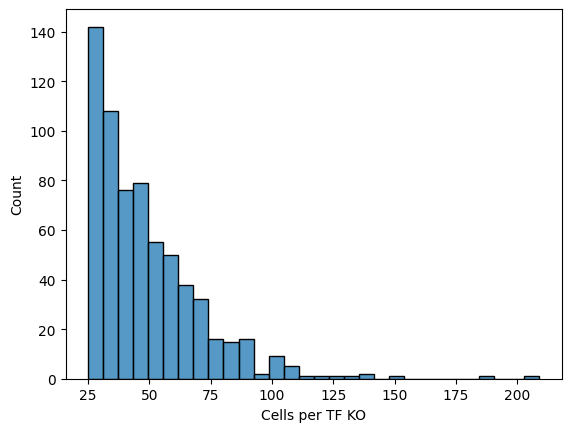

In [10]:
ax = sns.histplot(cells_per_tf_ko.values, bins=30)
p = plt.xlabel("Cells per TF KO")

## Display cells per batch in a dataset

In [ ]:
def cells_per_batch(adata, dataset_name):
    for run in "ALPHA", "BETA", "GAMMA":
        print(f"In {dataset_name}, run {run} has {adata[adata.obs['run'] == run].shape[0]} cells")

## Filter genes

Write function to get set of DEGs that pass LFC threshold based on differential gene expression data

In [24]:
def filter_degs_lfc(deg_df, lfc_threshold=0.25):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold
    lfc_degs = set()
    for pert in perts:
        deg_col = f"{pert}_DEGs"
        l2fc_col = f"{pert}_L2FC"
        if deg_col in deg_df.columns and l2fc_col in deg_df.columns:
            lfc_degs.update(deg_df.loc[deg_df[l2fc_col].abs() > lfc_threshold, deg_col])
    return lfc_degs

Generate set of DEGs

In [25]:
degs_filt = filter_degs_lfc(deg_df)
# Print results
degs_filt_list = list(degs_filt)
print(degs_filt_list[:10])
print(len(degs_filt))

['PSMD2', 'EIF1AX', 'ENSG00000288749', 'PCM1', 'ENSG00000291234', 'GLMN', 'SF3B3', 'POU5F1', 'KHDC4', 'RPS19BP1']
5820


Filter out genes that are present in fewer than 25 cells, based on study pipeline

In [13]:
sc.pp.filter_genes(adata_tfs, min_cells=25) # Filter for genes that are present in at least 25 cells
adata_tfs

filtered out 13046 genes that are detected in less than 25 cells


AnnData object with n_obs × n_vars = 31808 × 24521
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

### Test different gene filtering approaches with LFC threshold of 0.25

Generate set of 2000 HVGs

In [14]:
adata_tfs_2000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_2000_hvg, n_top_genes=2000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_2000 = set(adata_tfs_2000_hvg[:, adata_tfs_2000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 3000 HVGs

In [15]:
adata_tfs_3000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_3000_hvg, n_top_genes=3000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_3000 = set(adata_tfs_3000_hvg[:, adata_tfs_3000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 4000 HVGs

In [16]:
adata_tfs_4000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_4000_hvg, n_top_genes=4000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_4000 = set(adata_tfs_4000_hvg[:, adata_tfs_4000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 5000 HVGs

In [17]:
adata_tfs_5000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_5000_hvg, n_top_genes=5000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_5000 = set(adata_tfs_5000_hvg[:, adata_tfs_5000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Take union of set of DEGs that pass LFC threshold and set of HVGs

In [18]:
genes_union_2000 = list(degs_filt.union(unique_hvg_2000))
print(f"Number of genes in union of 5800 DEGs and 2000 HVGs: {len(genes_union_2000)}")
genes_union_3000 = list(degs_filt.union(unique_hvg_3000))
print(f"Number of genes in union of 5800 DEGs and 3000 HVGs: {len(genes_union_3000)}")
genes_union_4000 = list(degs_filt.union(unique_hvg_4000))
print(f"Number of genes in union of 5800 DEGs and 4000 HVGs: {len(genes_union_4000)}")
genes_union_5000 = list(degs_filt.union(unique_hvg_5000))
print(f"Number of genes in union of 5800 DEGs and 5000 HVGs: {len(genes_union_5000)}")

Number of genes in union of 5800 DEGs and 2000 HVGs: 7019
Number of genes in union of 5800 DEGs and 3000 HVGs: 7628
Number of genes in union of 5800 DEGs and 4000 HVGs: 8264
Number of genes in union of 5800 DEGs and 5000 HVGs: 8803


Take intersection of set of DEGs that pass LFC threshold and set of HVGs

In [19]:
genes_intersec_2000 = list(degs_filt.intersection(unique_hvg_2000))
print(f"Number of genes in intersection of 5800 DEGs and 2000 HVGs: {len(genes_intersec_2000)}")
genes_intersec_3000 = list(degs_filt.intersection(unique_hvg_3000))
print(f"Number of genes in intersection of 5800 DEGs and 3000 HVGs: {len(genes_intersec_3000)}")
genes_intersec_4000 = list(degs_filt.intersection(unique_hvg_4000))
print(f"Number of genes in intersection of 5800 DEGs and 4000 HVGs: {len(genes_intersec_4000)}")
genes_intersec_5000 = list(degs_filt.intersection(unique_hvg_5000))
print(f"Number of genes in intersection of 5800 DEGs and 5000 HVGs: {len(genes_intersec_5000)}")

Number of genes in intersection of 5800 DEGs and 2000 HVGs: 801
Number of genes in intersection of 5800 DEGs and 3000 HVGs: 1192
Number of genes in intersection of 5800 DEGs and 4000 HVGs: 1556
Number of genes in intersection of 5800 DEGs and 5000 HVGs: 2017


### Test different LFC thresholds

LFC threshold 0.5

In [14]:
degs_filt_05 = filter_degs_lfc(deg_df, lfc_threshold=0.5)
# Print results
degs_filt_list = list(degs_filt_05)
print(degs_filt_list[:10])
print(len(degs_filt_05))

['PSMD2', 'EIF1AX', 'ENSG00000288749', 'PCM1', 'ENSG00000291234', 'GLMN', 'SF3B3', 'POU5F1', 'KHDC4', 'RPS19BP1']
5818


LFC threshold 1

In [15]:
degs_filt_1 = filter_degs_lfc(deg_df, lfc_threshold=1)
# Print results
degs_filt_list = list(degs_filt_1)
print(degs_filt_list[:10])
print(len(degs_filt_1))

['PSMD2', 'ENSG00000288749', 'PCM1', 'ENSG00000291234', 'GLMN', 'SF3B3', 'POU5F1', 'KHDC4', 'RPS19BP1', 'LLGL2']
5343


LFC threshold 2

In [ ]:
degs_filt_2 = filter_degs_lfc(deg_df, lfc_threshold=2)
# Print results
degs_filt_list = list(degs_filt_2)
print(degs_filt_list[:10])
print(len(degs_filt_2))

['ENSG00000288765', 'SUCLG1', 'SULF1', 'RB1CC1', 'THAP9', 'HNRNPH2', 'ENSG00000288749', 'FABP7', 'ENSG00000291234', 'POU5F1']
2324


### Filter genes to the 5820 DEGs with LFC > 0.25

Filter genes in TF-KO-by-gene dataset to the 5820 DEGs that pass LFC threshold

In [9]:
adata_tfs_degs = adata_tfs[:, adata_tfs.var.index.isin(degs_filt)].copy()
adata_tfs_degs

NameError: name 'degs_filt' is not defined

In [ ]:
adata_tfs_degs.write("/home/ranwyl/data_tf_project/tf_kos_by_5820_degs.h5ad")

Filter genes in TF-KO-by-gene dataset to the intersection of 5820 DEGs + 5000 HVGs (2017 genes)

In [ ]:
adata_tfs_5000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_5000_hvg, n_top_genes=5000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_5000 = set(adata_tfs_5000_hvg[:, adata_tfs_5000_hvg.var['highly_variable']].var.index)
genes_intersec_5000 = list(degs_filt.intersection(unique_hvg_5000))
adata_tfs_intersec = adata_tfs[:, adata_tfs.var.index.isin(genes_intersec_5000)].copy()

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
adata_tfs_intersec

AnnData object with n_obs × n_vars = 31808 × 2017
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_intersec.write("/home/ranwyl/data_tf_project/tf_kos_by_2017_genes.h5ad")

### Filter genes to the 2324 DEGs with LFC > 2

Filter genes in TF-KO-by-gene dataset to the 2324 DEGs that pass LFC threshold of 2

In [ ]:
degs_filt_2 = filter_degs_lfc(deg_df, lfc_threshold=2)
adata_tfs_degs_2 = adata_tfs[:, adata_tfs.var.index.isin(degs_filt_2)].copy()
adata_tfs_degs_2

AnnData object with n_obs × n_vars = 31808 × 2324
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [27]:
adata_tfs_degs_2.write("/home/ranwyl/data_tf_project/tf_kos_by_2324_degs.h5ad")

### Filter genes to 2000 HVGs

In [25]:
adata_tfs_2000 = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_2000, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [26]:
adata_tfs_2000

AnnData object with n_obs × n_vars = 31808 × 2000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [27]:
adata_tfs_2000.write("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

### Filter genes to the intersection of 5820 DEGs and 5000 HVGs (2017 genes total)

Filter genes in TF-KO-by-gene dataset to the intersection of 5820 DEGs + 5000 HVGs (2017 genes)

In [22]:
adata_tfs_5000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_5000_hvg, n_top_genes=5000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_5000 = set(adata_tfs_5000_hvg[:, adata_tfs_5000_hvg.var['highly_variable']].var.index)
genes_intersec_5000 = list(degs_filt.intersection(unique_hvg_5000))
adata_tfs_intersec = adata_tfs[:, adata_tfs.var.index.isin(genes_intersec_5000)].copy()

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [23]:
adata_tfs_intersec

AnnData object with n_obs × n_vars = 31808 × 2017
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [24]:
adata_tfs_intersec.write("/home/ranwyl/data_tf_project/tf_kos_by_2017_genes.h5ad")

## Pairwise Pearson correlation matrix of mean profiles

### Modifying and testing code for plotting pairwise Pearson correlation matrix of mean profiles

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5800_degs.h5ad")

Write modified function for computing mean normalized profiles and generating pairwise Pearson correlation matrix that runs on a subset of the data

In [ ]:
def compute_mean_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    return mean_vector.A1 if hasattr(mean_vector, 'A1') else mean_vector

def test_create_corrmatrix(adata, n_gene_targets, n_jobs):
    # Subset gene targets for testing
    gene_target_list = sorted(adata.obs["gene_target"].unique().tolist())
    gene_targets = gene_target_list[:n_gene_targets]
    adata = adata[adata.obs["gene_target"].isin(gene_targets)].copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    print(f"Number of gene target groups: {len(gene_target_groups)}")

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    mean_profiles = np.array(mean_profiles)
    corr_matrix = np.corrcoef(mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_df = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_df,cmap="RdBu",xticklabels=False, yticklabels=False,vmax=1,vmin=-1,center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_df, mean_profiles)

Measure RAM usage with different values of `gene_target_groups`

-  20 targets, 20 jobs: before 157Gb, after 163 Gb = 6 Gb used
-  50 targets, 50 jobs: before 163 Gb, after 171 Gb = 8 Gb used
-  100 targets, 25 jobs: before 96Gb, after 90Gb somehow
-  250 targets, 25 jobs: before 90Gb, after 92Gb
-  500 targets, 25 jobs: before 92Gb, after 89Gb
-  Very fast and should be no problem to run on full dataset

Number of gene target groups: 500


Computing mean profiles:   0%|          | 0/500 [00:00<?, ?it/s]

/home/ranwyl/newenv/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/newenv/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


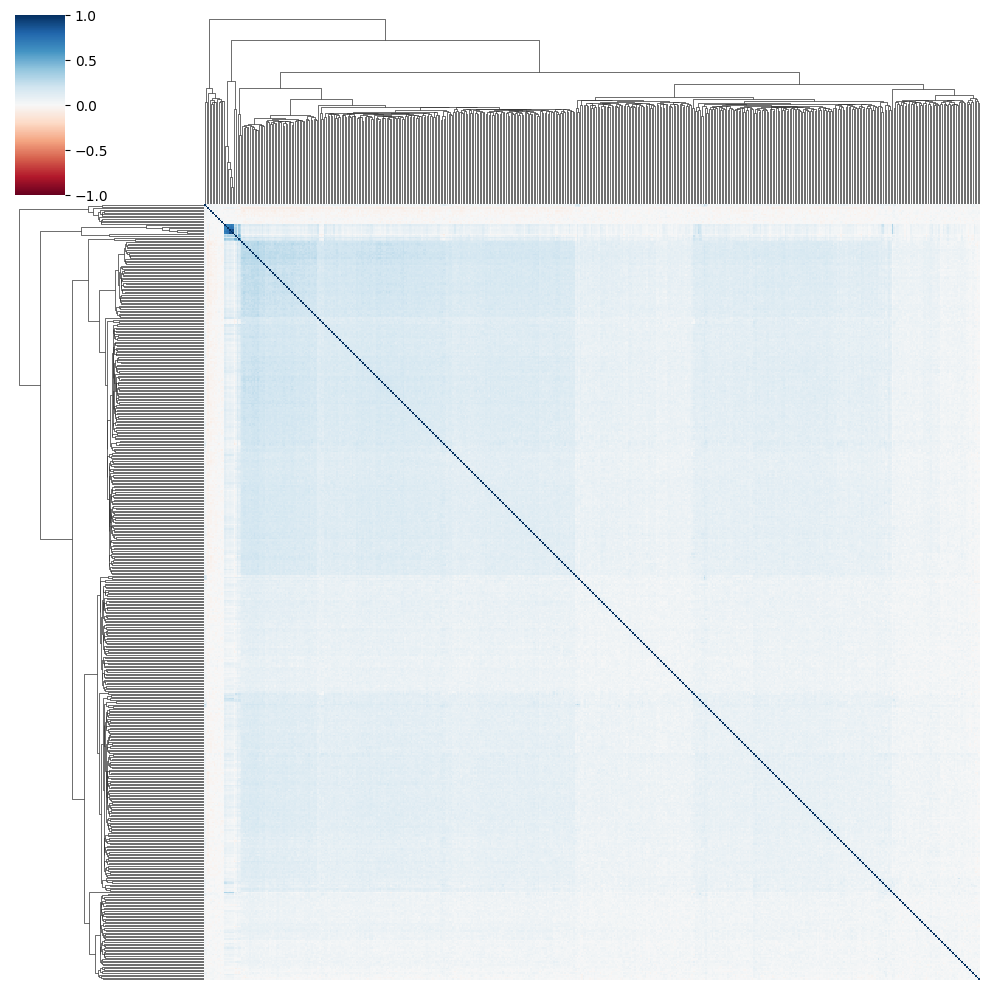

In [ ]:
ddf, mp = test_create_corrmatrix(adata, 500, 25)

### Pairwise Pearson correlation matrix of mean profiles - final function

In [28]:
def create_corrmatrix_parallel(adata, n_jobs):
    gene_target_groups = adata.obs.groupby('gene_target').indices
    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        adata_mean_profiles = Parallel(n_jobs=n_jobs)(delayed(qc2.compute_mean_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    adata_mean_profiles = np.array(adata_mean_profiles)
    corr_matrix = np.corrcoef(adata_mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_dataframe = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_dataframe,cmap="RdBu",xticklabels=False, yticklabels=False,vmax=1,vmin=-1,center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_dataframe, adata_mean_profiles)

### Pairwise Pearson correlation matrix of mean profiles for 5820-gene dataset

In [4]:
adata_5820 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5820_degs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


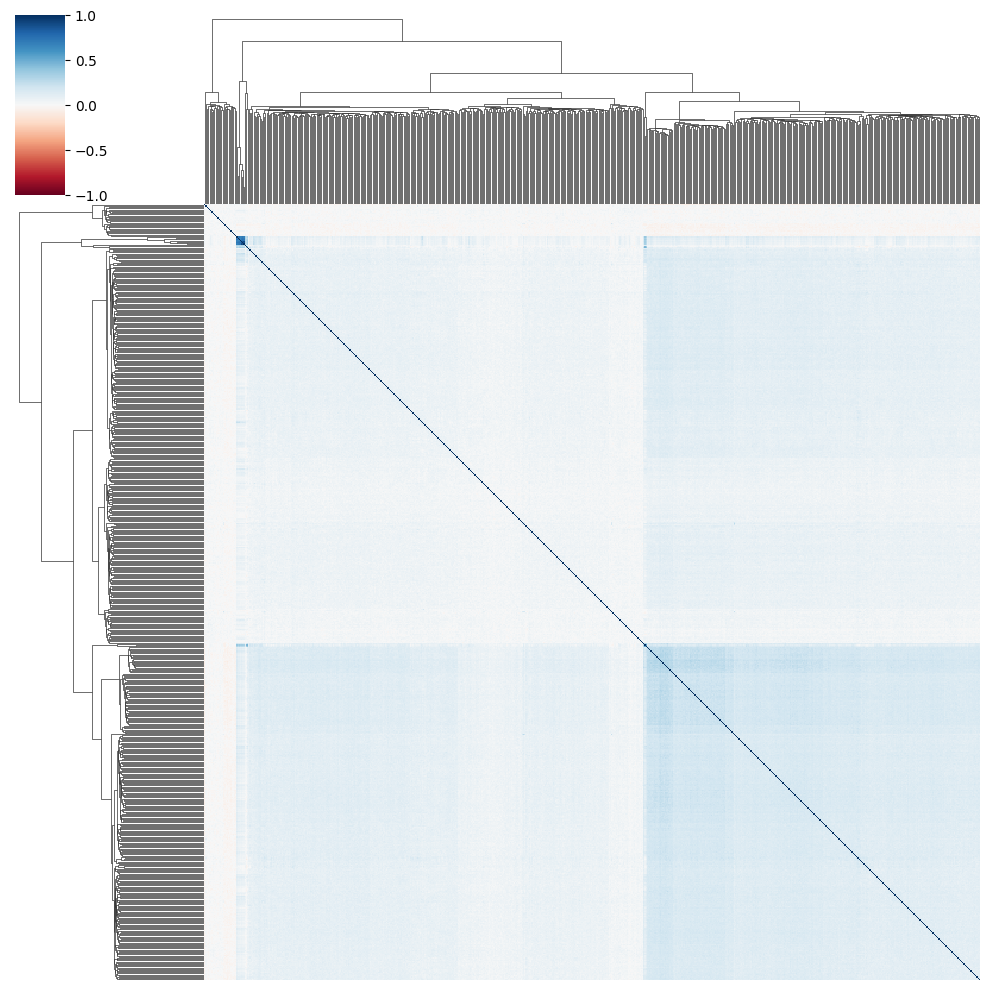

In [5]:
distance_df_5820, mean_profiles_5820 = create_corrmatrix_parallel(adata_5820, 25)

### Pairwise Pearson correlation matrix of mean profiles for 2324-gene dataset

In [29]:
adata_2324 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2324_degs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


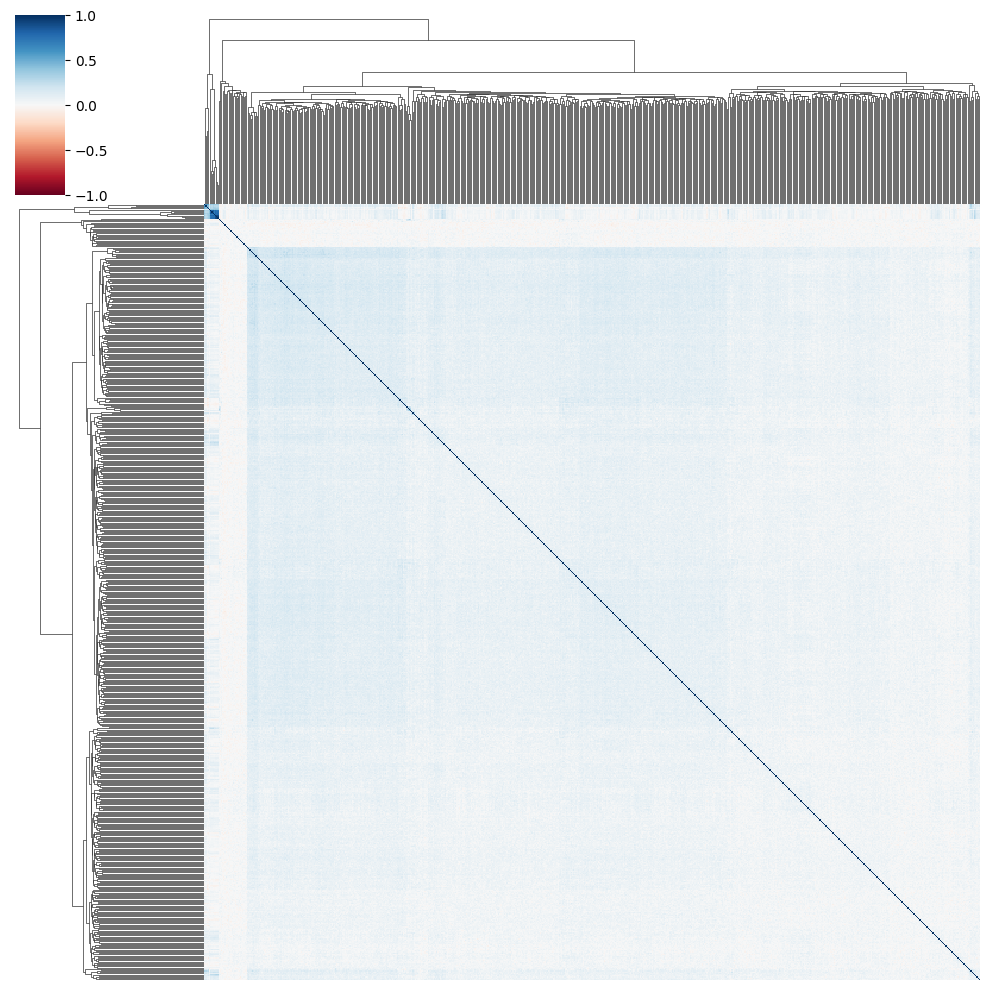

In [30]:
distance_df_2324, mean_profiles_2324 = create_corrmatrix_parallel(adata_2324, 25)

### Pairwise Pearson correlation matrix of mean profiles for 2000-gene dataset

In [8]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


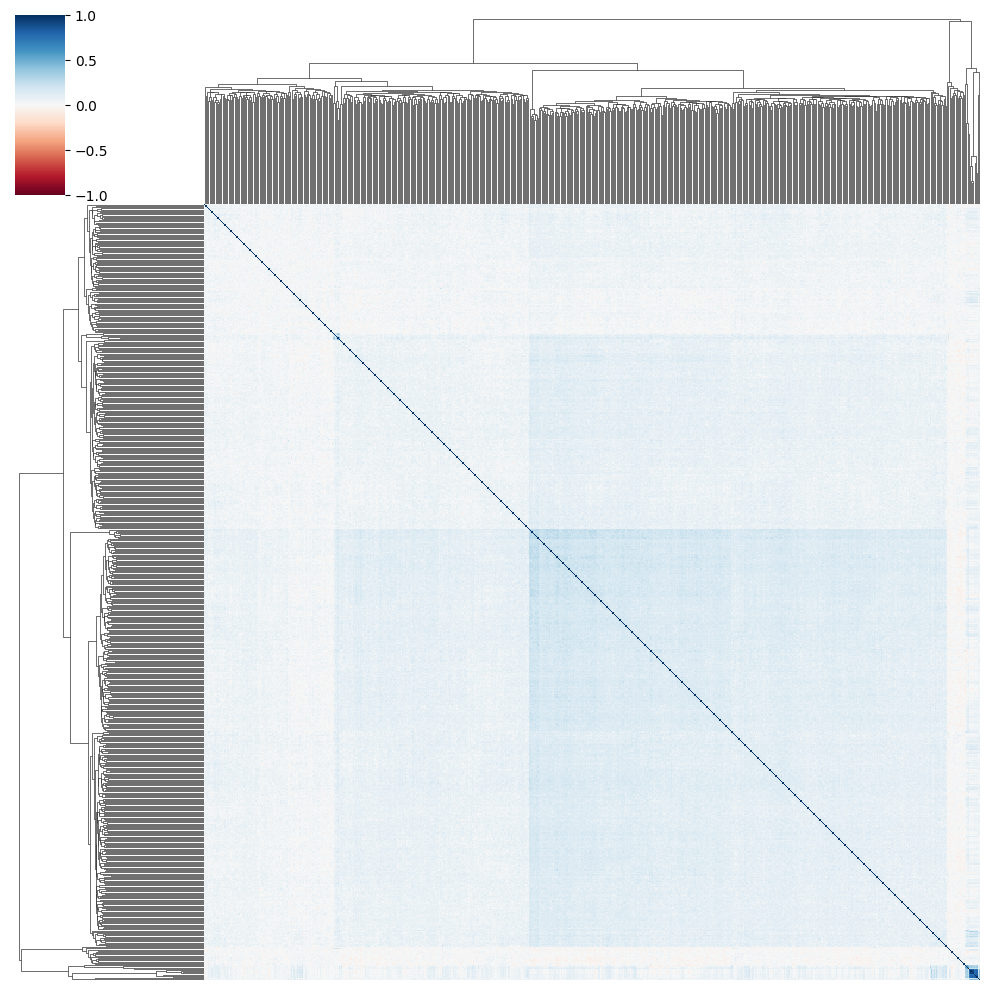

In [9]:
distance_df_2000, mean_profiles_2000 = create_corrmatrix_parallel(adata_2000, 25)

### Pairwise Pearson correlation matrix of mean profiles for 2017-gene dataset

In [6]:
adata_2017 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2017_genes.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


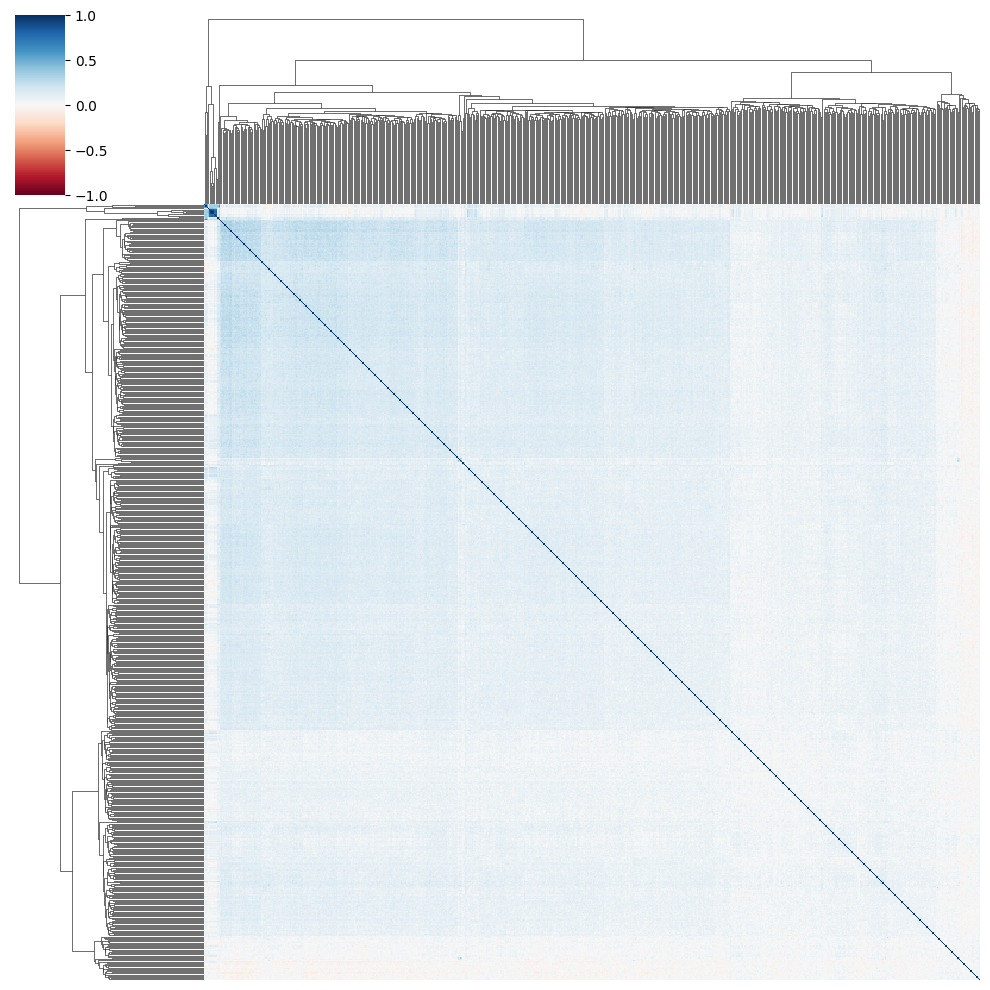

In [7]:
distance_df_2017, mean_profiles_2017 = create_corrmatrix_parallel(adata_2017, 25)

## MDE

### Modifying and testing code for mean normalized expression profile pairwise Pearson correlation matrix + MDE

In [ ]:
# def compute_mean_normalized_profile(adata, group_indices):
#     mean_vector = adata[group_indices, :].X.mean(axis=0)
#     normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
#     return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

# def test_tf_compute_MDE(adata, n_gene_targets, n_jobs, leiden_neighbors=5, preserve='neighbors', spectral=False):
#     adata = adata.copy()

#     # Subset gene targets for testing
#     gene_target_list = sorted(adata.obs["gene_target"].unique().tolist())
#     gene_targets = gene_target_list[:n_gene_targets]
#     adata = adata[adata.obs["gene_target"].isin(gene_targets)].copy()
#     gene_target_groups = adata.obs.groupby('gene_target').indices
#     print(f"Number of gene target groups: {len(gene_target_groups)}")

#     # Initialize tqdm progress bar
#     with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
#         # Compute the mean expression profile for each group in parallel
#         mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
#                                                 for indices in gene_target_groups.values())
    
#     # Convert the list of mean profiles to a numpy array
#     mean_profiles_array = np.array(mean_profiles)

#     # Compute MDE
#     mde = None
#     embedding = None
#     if preserve == "neighbors":
#         if spectral:
#             spectral_embedding = SpectralEmbedding(
#                 n_components=30,  # Ensure this matches the pymde embedding dimension
#                 affinity='nearest_neighbors',
#                 n_neighbors=10,
#                 eigen_solver='arpack'
#             )
#             initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
#             mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
#             embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
#         else:
#             mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
#             embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
#     else:
#         mde = pymde.preserve_distances(mean_profiles_array)
#         embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
#     # Run Leiden clustering on the embeddings
#     knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
#     sources, targets = knn_graph.nonzero()
#     g = ig.Graph(directed=False)
#     g.add_vertices(embedding.shape[0])
#     g.add_edges(zip(sources, targets))
#     partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
#     # Get cluster labels and make pairwise correlation plot
#     clusters = np.array(partition.membership)
#     gene_targets = list(gene_target_groups.keys())
#     embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
#     embedding_df['gene_target'] = gene_targets
#     embedding_df['cluster'] = clusters
#     embedding_df['cluster'] = embedding_df['cluster'].astype(str)
#     cluster_groups = embedding_df.groupby('cluster')
#     centroids = cluster_groups[['x', 'y']].mean()
#     pairwise_distances = pd.DataFrame(
#         squareform(pdist(centroids, metric='euclidean')),
#         index=centroids.index,
#         columns=centroids.index
#     )
#     sns.clustermap(pairwise_distances, cmap='PuBuGn')
#     plt.title('Pairwise Distance Matrix of Cluster Centroids')
#     plt.show()


#     # Plot using Plotly with Pastel colormap for discrete clusters
#     fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
#                      hover_data={'x': True, 'y': True, 'gene_target': True},
#                      title='MDE Embedding of Mean Normalized Profiles',
#                      color_discrete_sequence=px.colors.qualitative.Bold)
#     fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
#     fig.update_layout(
#         showlegend=True,
#         xaxis=dict(visible=False),
#         yaxis=dict(visible=False),
#         plot_bgcolor='white',
#         width=1200,  # Increase plot width
#         height=1000,  # Increase plot height
#         legend_title_text='Cluster',
#         coloraxis_showscale=False
#     )
   
#     fig.show()
    
#     return adata, embedding, clusters, mean_profiles_array

Tested different dataset sizes and monitor RAM + time elapsed (results not shown) - it works

Now we want to test why we are getting the error message: 

"/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,"

In [ ]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def test_tf_compute_MDE(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()


    # # Plot using Plotly with Pastel colormap for discrete clusters
    # fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
    #                  hover_data={'x': True, 'y': True, 'gene_target': True},
    #                  title='MDE Embedding of Mean Normalized Profiles',
    #                  color_discrete_sequence=px.colors.qualitative.Bold)
    # fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
    # fig.update_layout(
    #     showlegend=True,
    #     xaxis=dict(visible=False),
    #     yaxis=dict(visible=False),
    #     plot_bgcolor='white',
    #     width=1200,  # Increase plot width
    #     height=1000,  # Increase plot height
    #     legend_title_text='Cluster',
    #     coloraxis_showscale=False
    # )
    # if not label_points:
    #     fig.update_traces(text=None)
   
    # fig.show()
    
    return adata, embedding, clusters, mean_profiles_array

def test_tf_compute_MDE_2(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    return embedding_df
    
    # pairwise_distances = pd.DataFrame(
    #     squareform(pdist(centroids, metric='euclidean')),
    #     index=centroids.index,
    #     columns=centroids.index
    # )
    # sns.clustermap(pairwise_distances, cmap='PuBuGn')
    # plt.title('Pairwise Distance Matrix of Cluster Centroids')
    # plt.show()

In [ ]:
adata_2012 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2012_genes.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 17 02:04:56 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 128898 edges.
Apr 17 02:04:56 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 17 02:04:56 PM: iteration 0000 | distortion 0.974530 | residual norm 0.111911 | step length 1.73742 | percent change 0.538439
Apr 17 02:04:57 PM: iteration 0100 | distortion 0.139406 | residual norm 0.000115798 | step length 1 | percent change 0.30733
Apr 17 02:04:58 PM: iteration 0200 | distortion 0.137794 | residual norm 4.5249e-05 | step length 1 | percent change 0.0578183
Apr 17 02:05:00 PM: iteration 0300 | distortion 0.137382 | residual norm 6.20392e-05 | step length 1 | percent change 0.293795
Apr 17 02:05:01 PM: Converged in 385 iterations, with residual norm 8.46434e-06
Apr 17 02:05:01 PM: Finished fitting in 5.323 seconds and 385 iterations.
Apr 17 02:05:01 PM: average distortion 0.137 | residual norm 8.5e-06


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


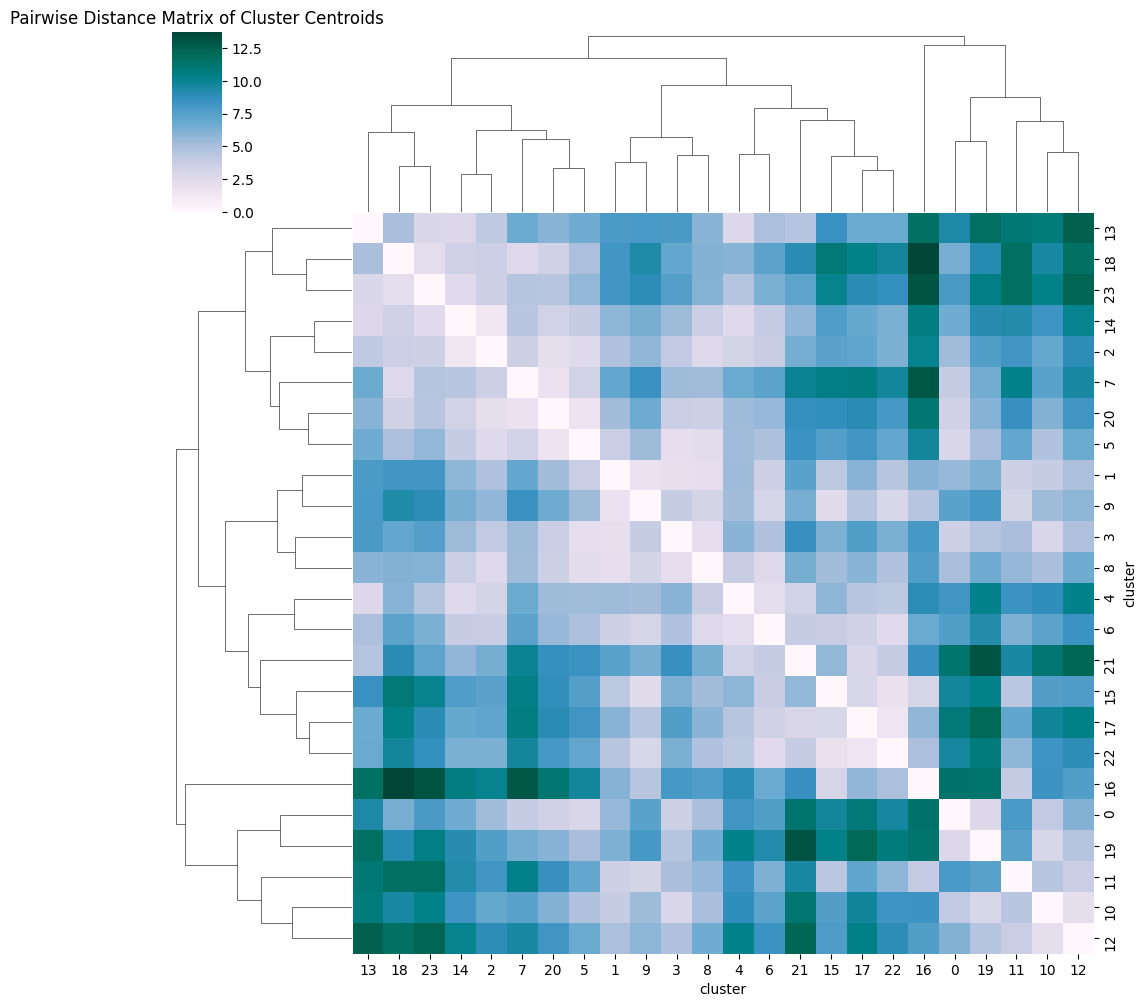

In [ ]:
test_adata, test_embedding, test_clusters, test_mp = test_tf_compute_MDE(adata_2012, 5, spectral=True, leiden_neighbors=8)

In [ ]:
test_embedding_df = test_tf_compute_MDE_2(adata_2012, 5, spectral=True, leiden_neighbors=8)

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 17 02:13:34 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 128922 edges.
Apr 17 02:13:34 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 17 02:13:34 PM: iteration 0000 | distortion 0.973552 | residual norm 0.114345 | step length 0.311499 | percent change 0.0986355
Apr 17 02:13:37 PM: iteration 0100 | distortion 0.141704 | residual norm 0.000205405 | step length 1 | percent change 0.499116
Apr 17 02:13:40 PM: iteration 0200 | distortion 0.140230 | residual norm 0.000120667 | step length 0.631188 | percent change 0.733236
Apr 17 02:13:43 PM: iteration 0300 | distortion 0.139719 | residual norm 3.67199e-05 | step length 1 | percent change 0.130888
Apr 17 02:13:45 PM: iteration 0400 | distortion 0.139194 | residual norm 7.99929e-05 | step length 1 | percent change 0.424733
Apr 17 02:13:47 PM: iteration 0500 | distortion 0.138897 | residual norm 1.91764e-05 | step length 1 | percent change 0.044975
Apr 17 02:13:49 PM: iteration 06

In [ ]:
cluster_groups = test_embedding_df.groupby('cluster')
centroids = cluster_groups[['x', 'y']].mean()
centroids

x         y
cluster                    
0       -0.046596 -0.406438
1       -1.316051  1.885311
10       1.190665 -1.900266
11       0.748815  1.298265
12      -1.312611 -5.399751
13      -4.194056  3.612322
14       6.250611 -1.030417
15      -7.694043 -0.612885
16       2.545876  1.978286
17       0.848415  6.816499
18      -3.844777 -4.329384
19       3.129081 -5.663320
2       -2.514124 -2.058999
20      -6.057180 -2.377816
21      -2.126464  6.845334
3        2.906401 -0.673219
4        2.649839  4.063341
5       -4.382234  0.926447
6        3.528181 -3.107324
7        0.676794 -4.347167
8        4.879872  1.103764
9       -1.662272  5.090614

In [ ]:
pdist_mat = pdist(centroids, metric='euclidean')
pdist_mat.shape

(231,)

In [ ]:
pdist_mat

array([ 2.6198535 ,  1.93967396,  1.88114091,  5.15130746,  5.77510693,
        6.3280459 ,  7.65023314,  3.52247346,  7.27817722,  5.46037413,
        6.14163921,  2.96979007,  6.32561903,  7.54414014,  2.96502353,
        5.2201237 ,  4.53589409,  4.48038145,  4.00657474,  5.15274694,
        5.72957208,  4.54028841,  2.14669419,  7.28506336,  3.35640856,
        8.10899801,  6.8498005 ,  3.8630458 ,  5.38530643,  6.70946324,
        8.76019619,  4.12225246,  6.37593635,  5.02579284,  4.93712263,
        4.52461074,  3.21261507,  6.95650762,  6.54333446,  6.24502085,
        3.22394729,  3.22890523,  4.30264898,  7.70609141,  5.1341689 ,
        8.97749317,  4.10849859,  8.72348079,  5.59073271,  4.23297008,
        3.70818788,  7.26356072,  9.35354785,  2.10935912,  6.13952743,
        6.24879988,  2.63077424,  2.50027825,  4.7575672 ,  7.55060621,
        7.00805935,  5.45773171,  5.97432161,  8.65646275,  1.92142025,
        5.51913268,  7.2644011 ,  7.35726384,  4.68166575,  7.73

In [ ]:
squareform_mat = squareform(pdist_mat)
squareform_mat.shape

(22, 22)

In [ ]:
squareform_mat

array([[ 0.        ,  2.6198535 ,  1.93967396,  1.88114091,  5.15130746,
         5.77510693,  6.3280459 ,  7.65023314,  3.52247346,  7.27817722,
         5.46037413,  6.14163921,  2.96979007,  6.32561903,  7.54414014,
         2.96502353,  5.2201237 ,  4.53589409,  4.48038145,  4.00657474,
         5.15274694,  5.72957208],
       [ 2.6198535 ,  0.        ,  4.54028841,  2.14669419,  7.28506336,
         3.35640856,  8.10899801,  6.8498005 ,  3.8630458 ,  5.38530643,
         6.70946324,  8.76019619,  4.12225246,  6.37593635,  5.02579284,
         4.93712263,  4.52461074,  3.21261507,  6.95650762,  6.54333446,
         6.24502085,  3.22394729],
       [ 1.93967396,  4.54028841,  0.        ,  3.22890523,  4.30264898,
         7.70609141,  5.1341689 ,  8.97749317,  4.10849859,  8.72348079,
         5.59073271,  4.23297008,  3.70818788,  7.26356072,  9.35354785,
         2.10935912,  6.13952743,  6.24879988,  2.63077424,  2.50027825,
         4.7575672 ,  7.55060621],
       [ 1.88114091

### MDE function

In [2]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def tf_compute_MDE(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()


    # Plot using Plotly with Pastel colormap for discrete clusters
    fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
                     hover_data={'x': True, 'y': True, 'gene_target': True},
                     title='MDE Embedding of Mean Normalized Profiles',
                     color_discrete_sequence=px.colors.qualitative.Bold)
    fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
    fig.update_layout(
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor='white',
        width=1200,  # Increase plot width
        height=1000,  # Increase plot height
        legend_title_text='Cluster',
        coloraxis_showscale=False
    )
    if not label_points:
        fig.update_traces(text=None)
   
    fig.show()
    
    return adata, embedding, clusters, mean_profiles_array

### MDE on 5820 gene dataset

In [10]:
adata_5820 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5820_degs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 21 02:03:19 AM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Apr 21 02:03:19 AM: The following items have duplicates [ 96 149]
Apr 21 02:03:19 AM: Fitting a centered embedding into R^2, for a graph with 652 items and 133176 edges.
Apr 21 02:03:19 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 21 02:03:19 AM: iteration 0000 | distortion 0.805947 | residual norm 0.0813781 | step length 2.4525 | percent change 0.552686
Apr 21 02:03:22 AM: iteration 0100 | distortion 0.136780 | residual norm 0.000154311 | step length 1 | percent change 0.433389
Apr 21 02:03:26 AM: iteration 0200 | distortion 0.135049 | residual norm 9.19347e-05 | step length 1 | percent change 1.10459
Apr 21 02:03:29 AM: iteration 0300 | distortion 0.134549 | residual norm 0.000122142 | step length 1 | percent change 0.718596
Apr 21 02:03:32 AM: iteration 0400 | distortion 0.134202 | residual norm 1.6193e-05 | step length

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



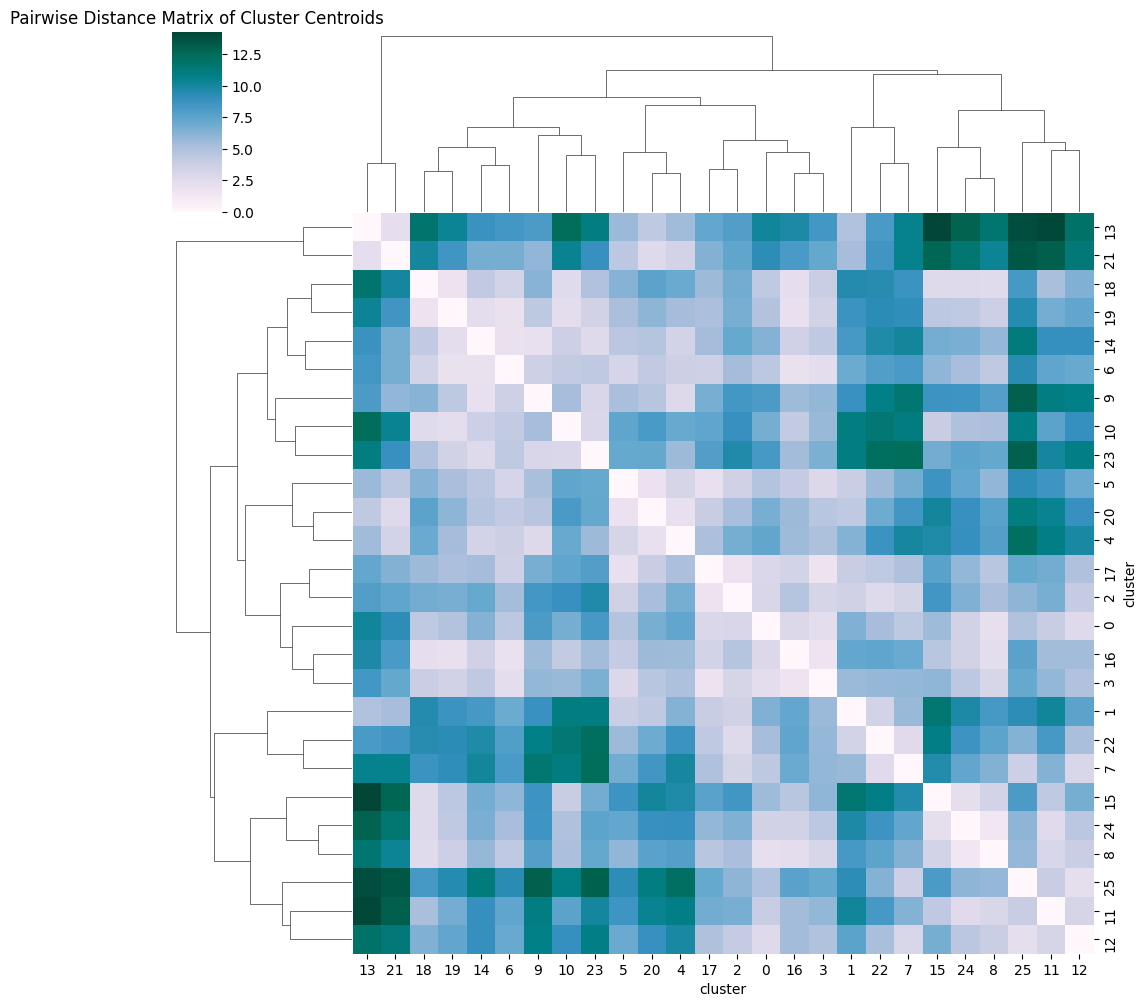

In [11]:
mde_5820 = tf_compute_MDE(adata_5820, n_jobs=5, label_points=False, spectral=True,leiden_neighbors=8)

### MDE on 2324 gene dataset

In [12]:
adata_2324 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2324_degs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 21 02:05:18 AM: Fitting a centered embedding into R^2, for a graph with 652 items and 127064 edges.
Apr 21 02:05:18 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 21 02:05:18 AM: iteration 0000 | distortion 0.862958 | residual norm 0.0824132 | step length 0.426221 | percent change 0.0972731
Apr 21 02:05:21 AM: iteration 0100 | distortion 0.139619 | residual norm 0.000164302 | step length 1 | percent change 0.344872
Apr 21 02:05:24 AM: iteration 0200 | distortion 0.137891 | residual norm 0.000130736 | step length 1 | percent change 0.174981
Apr 21 02:05:27 AM: iteration 0300 | distortion 0.136872 | residual norm 6.71833e-05 | step length 1 | percent change 0.297267
Apr 21 02:05:30 AM: iteration 0400 | distortion 0.136558 | residual norm 3.60009e-05 | step length 1 | percent change 0.0730612
Apr 21 02:05:32 AM: iteration 0500 | distortion 0.136422 | residual norm 4.68058e-05 | step length 1 | percent change 0.0392103
Apr 21 02:05:35 AM: iteration 0600 |

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



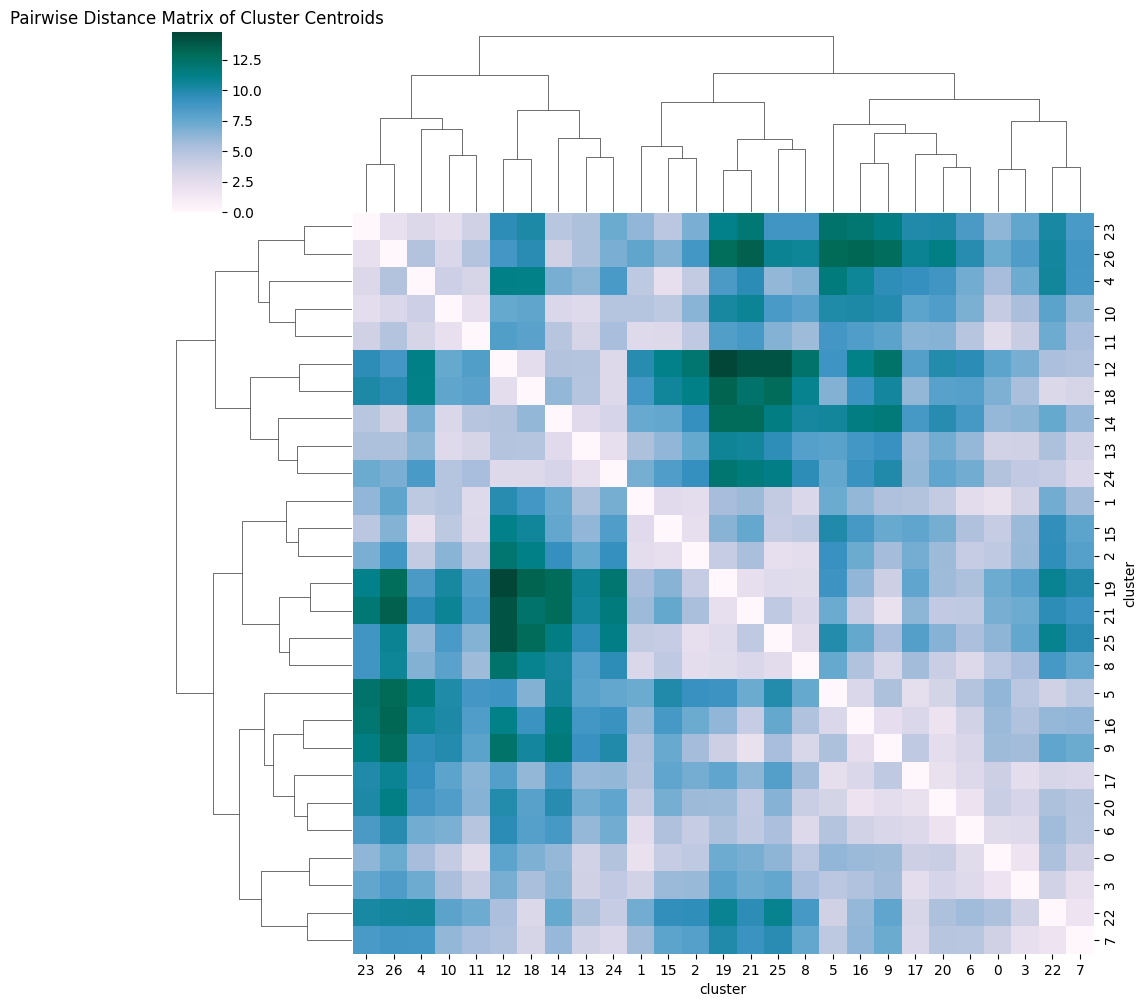

In [13]:
mde_2324 = tf_compute_MDE(adata_2324, n_jobs=5, label_points=False, spectral=True,leiden_neighbors=8)

### MDE on 2000 gene dataset

In [ ]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 21 02:08:44 AM: Fitting a centered embedding into R^2, for a graph with 652 items and 129668 edges.
Apr 21 02:08:44 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 21 02:08:44 AM: iteration 0000 | distortion 0.799080 | residual norm 0.0725806 | step length 2.67586 | percent change 0.537831
Apr 21 02:08:47 AM: iteration 0100 | distortion 0.139832 | residual norm 9.0516e-05 | step length 1 | percent change 0.871558
Apr 21 02:08:50 AM: iteration 0200 | distortion 0.139041 | residual norm 3.24893e-05 | step length 1 | percent change 0.0257249
Apr 21 02:08:53 AM: iteration 0300 | distortion 0.138875 | residual norm 3.49794e-05 | step length 1 | percent change 0.223693
Apr 21 02:08:57 AM: iteration 0400 | distortion 0.138529 | residual norm 3.77277e-05 | step length 1 | percent change 0.125329
Apr 21 02:09:00 AM: iteration 0500 | distortion 0.138367 | residual norm 1.15227e-05 | step length 1 | percent change 0.0666757
Apr 21 02:09:00 AM: Converged in 505 it

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



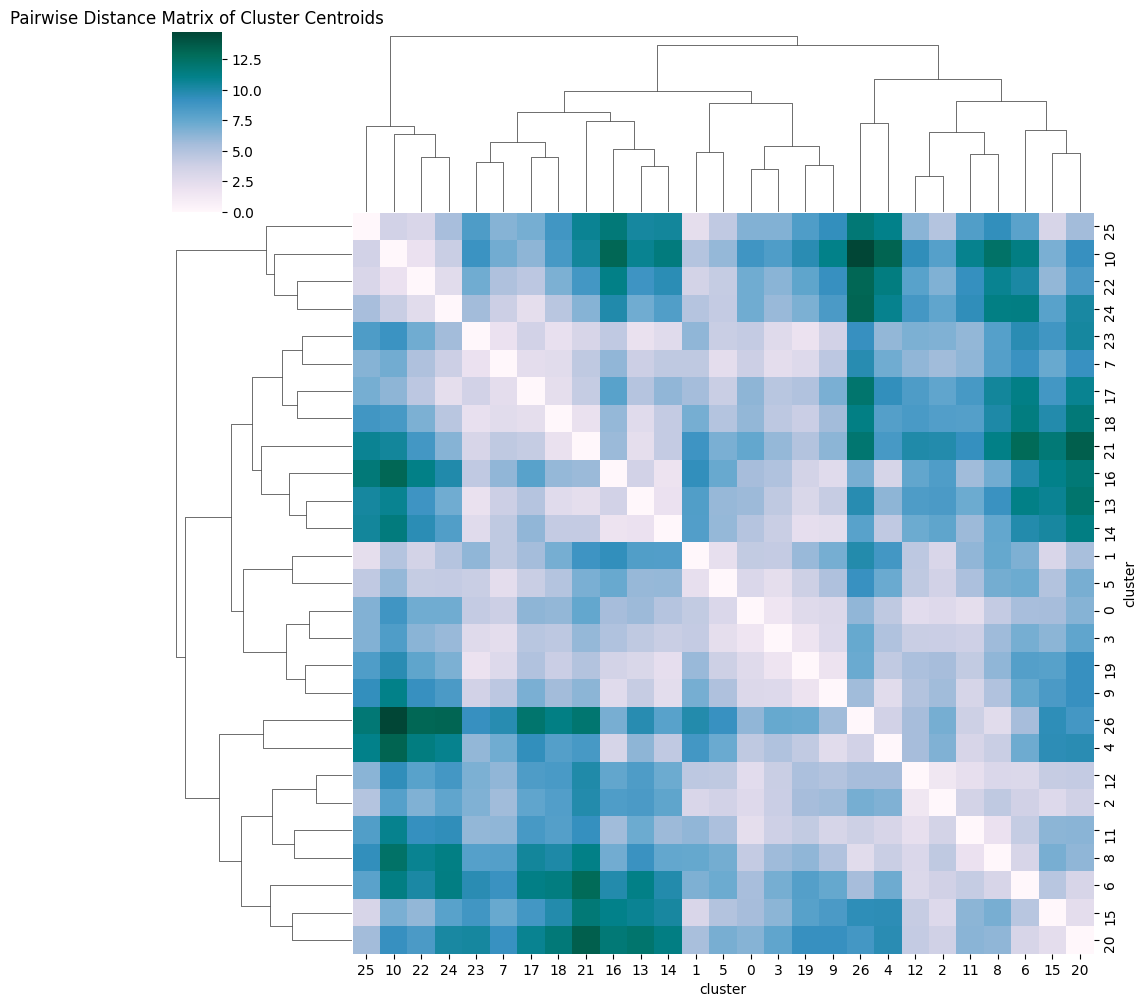

In [15]:
mde_2000 = tf_compute_MDE(adata_2000, n_jobs=5, label_points=False, spectral=True,leiden_neighbors=8)

### MDE on 2017 gene dataset

In [16]:
adata_2017 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2017_genes.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 21 02:11:01 AM: Fitting a centered embedding into R^2, for a graph with 652 items and 128670 edges.
Apr 21 02:11:01 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 21 02:11:01 AM: iteration 0000 | distortion 0.928323 | residual norm 0.0946834 | step length 11.2357 | percent change 2.94601
Apr 21 02:11:02 AM: iteration 0100 | distortion 0.139795 | residual norm 0.000166792 | step length 1 | percent change 1.7624
Apr 21 02:11:04 AM: iteration 0200 | distortion 0.138356 | residual norm 9.37202e-05 | step length 1 | percent change 0.522527
Apr 21 02:11:05 AM: iteration 0300 | distortion 0.137983 | residual norm 2.30281e-05 | step length 1 | percent change 0.0933294
Apr 21 02:11:07 AM: iteration 0400 | distortion 0.137826 | residual norm 2.59021e-05 | step length 1 | percent change 0.118517
Apr 21 02:11:08 AM: iteration 0500 | distortion 0.137652 | residual norm 2.24556e-05 | step length 1 | percent change 0.0840364
Apr 21 02:11:10 AM: iteration 0600 | dist

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



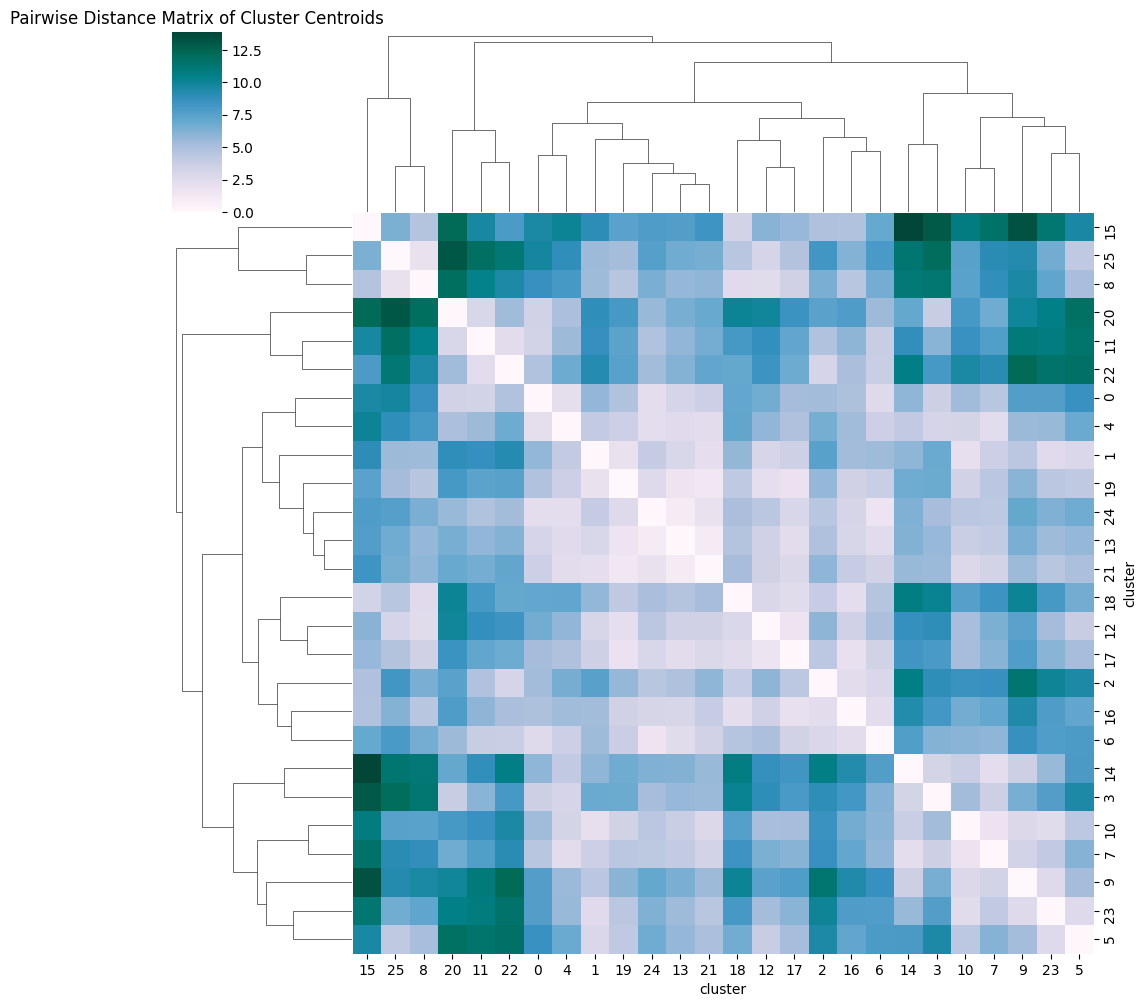

In [17]:
mde_2017 = tf_compute_MDE(adata_2017, n_jobs=5, label_points=False, spectral=True,leiden_neighbors=8)